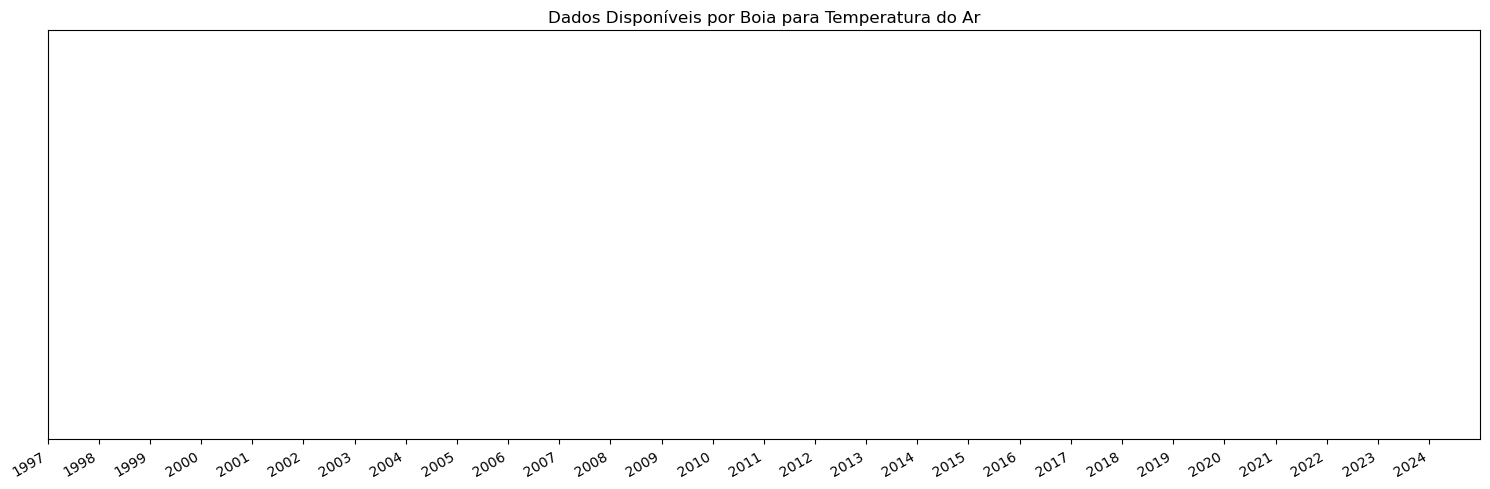

In [1]:
import glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime

# Função para ler os dados de cada arquivo NetCDF
def ler_dados(arquivo):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]
    temperatura = ds.variables['AT_21'][:]
    
    fill_value = 1e35
    temperatura = np.where(temperatura == fill_value, np.nan, temperatura)
    temperatura = temperatura.squeeze()

    datas = nc.num2date(tempo, units=ds.variables['time'].units)
    ds.close()

    return lat.mean(), lon.mean(), datas, temperatura

# Caminho para os arquivos NetCDF
caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/AirT/*.cdf"
arquivos_netCDF = glob.glob(caminho_pasta)

# Ler dados de todas as boias
dados_boias = [ler_dados(arquivo) for arquivo in arquivos_netCDF]

# Ordenar os dados das boias pela latitude (do norte para o sul)
dados_boias.sort(key=lambda x: x[0], reverse=True)

# Função para plotar as séries temporais
def plotar_series_temporais(dados_boias, titulo):
    plt.figure(figsize=(15,5))
    
    plt.title(titulo)
    plt.xlabel('')
    plt.ylabel('')

    for i, (lat, lon, datas, temperatura) in enumerate(dados_boias):
        datas_convertidas = [datetime.datetime(date.year, date.month, date.day) for date in datas]
        datas_num = mdates.date2num(datas_convertidas)

        inicio_periodo = None
        for j, temp in enumerate(temperatura):
            if inicio_periodo is None and not np.isnan(temp):
                inicio_periodo = datas_num[j]
            elif inicio_periodo is not None and np.isnan(temp):
                fim_periodo = datas_num[j - 1]
                plt.hlines(y=i, xmin=inicio_periodo, xmax=fim_periodo, colors='r', linestyles='solid', linewidth=2)
                inicio_periodo = None

        if inicio_periodo is not None and not np.isnan(temperatura[-1]):
            fim_periodo = datas_num[-1]
            plt.hlines(y=i, xmin=inicio_periodo, xmax=fim_periodo, colors='r', linestyles='solid', linewidth=2)

    plt.yticks(range(len(dados_boias)), [f'Boia {i+1} (Lat: {lat:.1f}, Lon: {lon:.1f})' for i, (_, _, _, _) in enumerate(dados_boias)])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xlim([mdates.date2num(datetime.datetime(1997, 1, 1)), mdates.date2num(datetime.datetime(2024, 12, 31))])
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Chamar a função de plotagem com os dados ordenados
plotar_series_temporais(dados_boias, "Dados Disponíveis por Boia para Temperatura do Ar")

# Preenchimento método linear



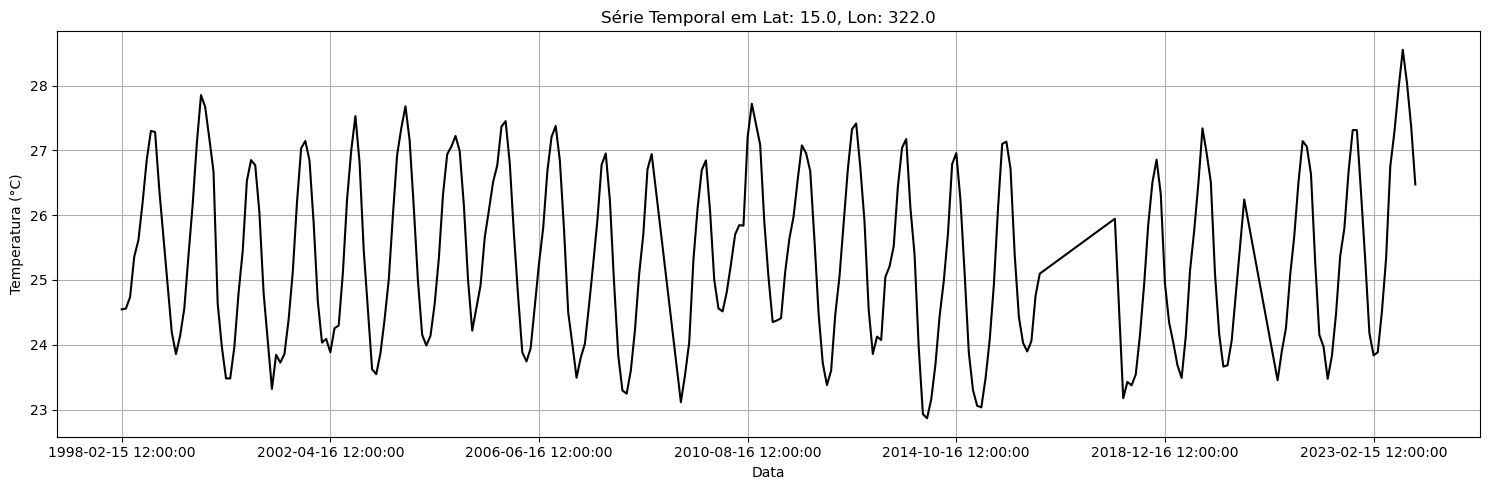

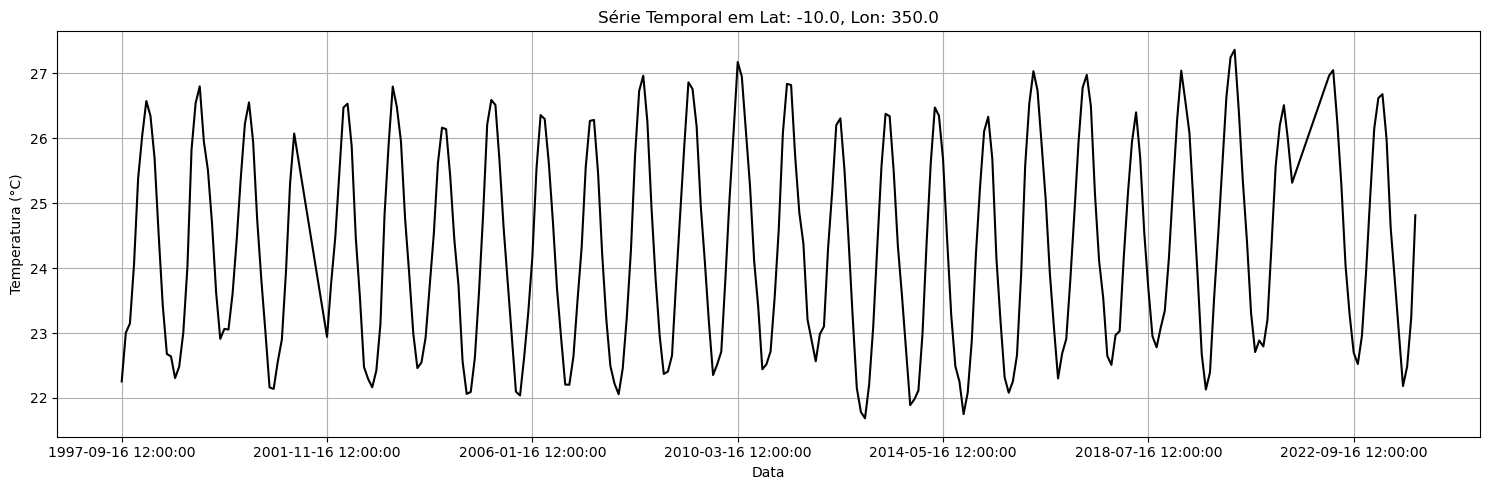

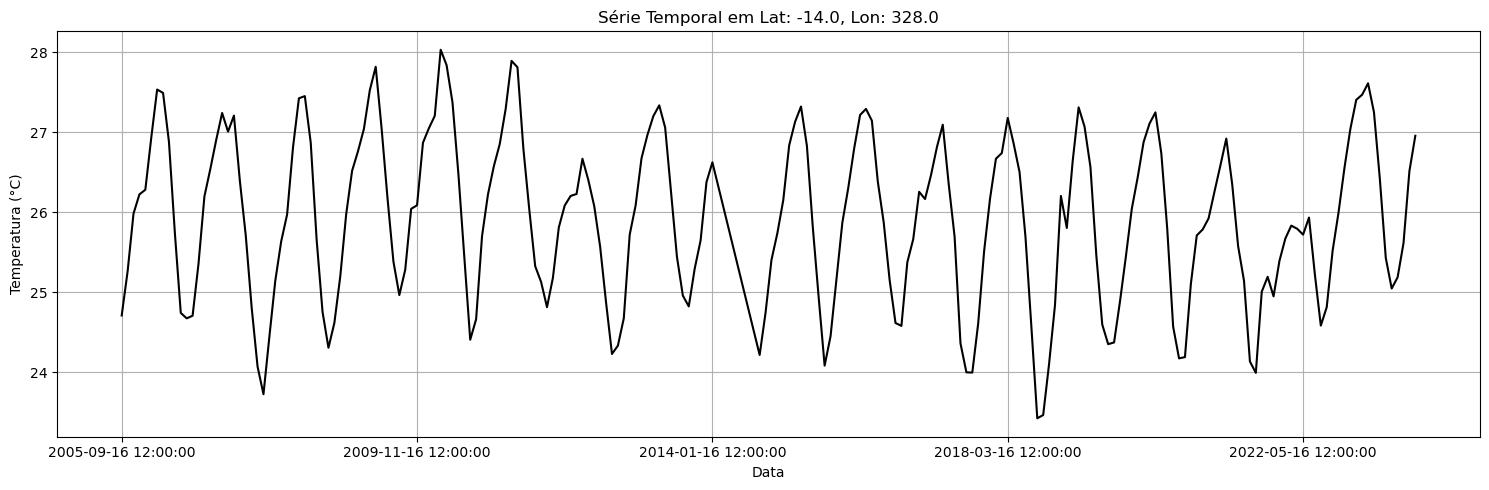

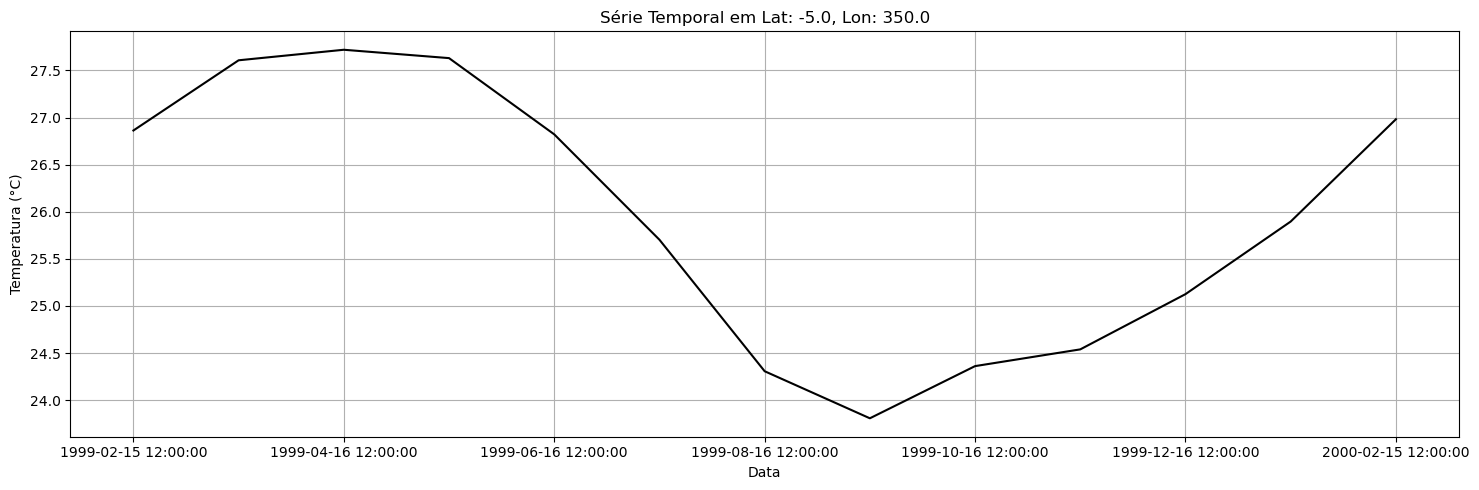

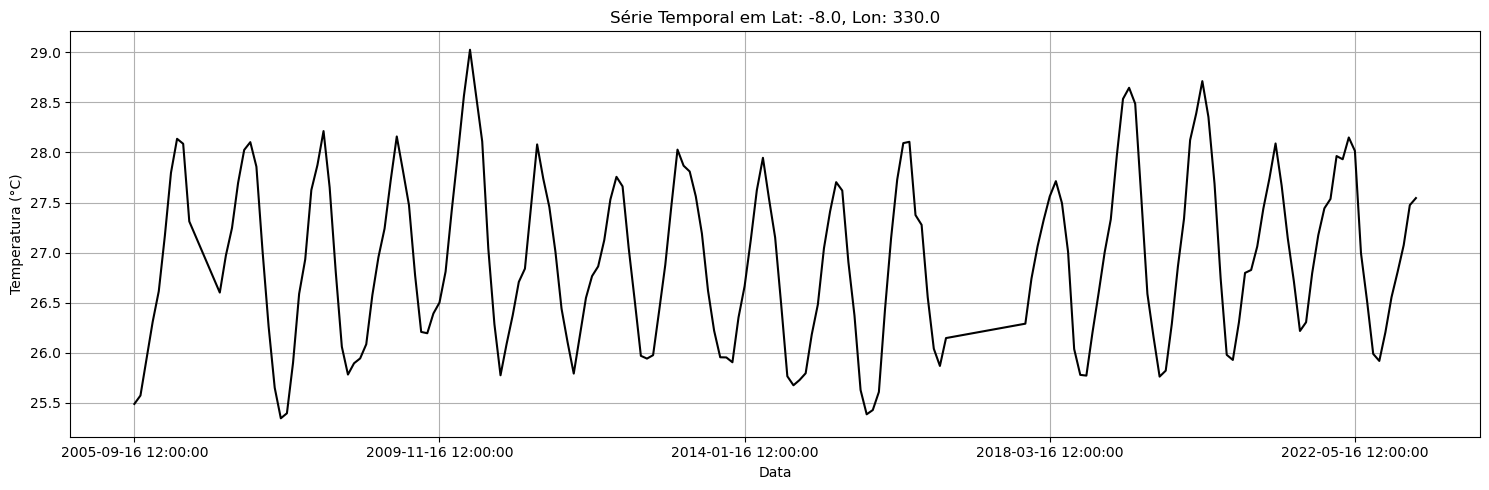

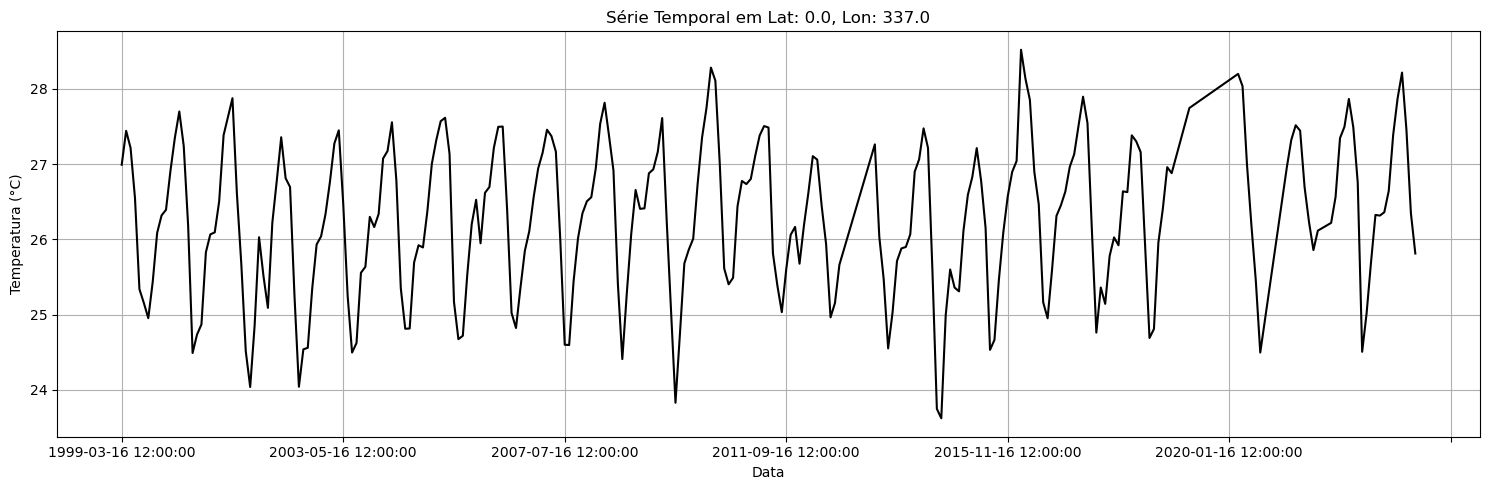

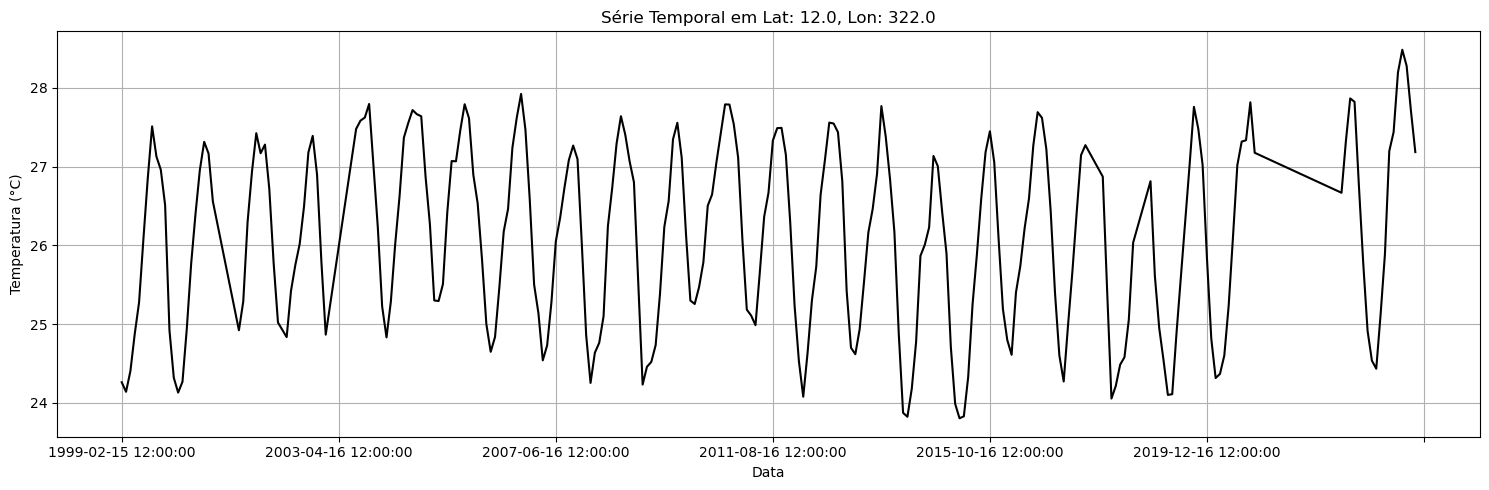

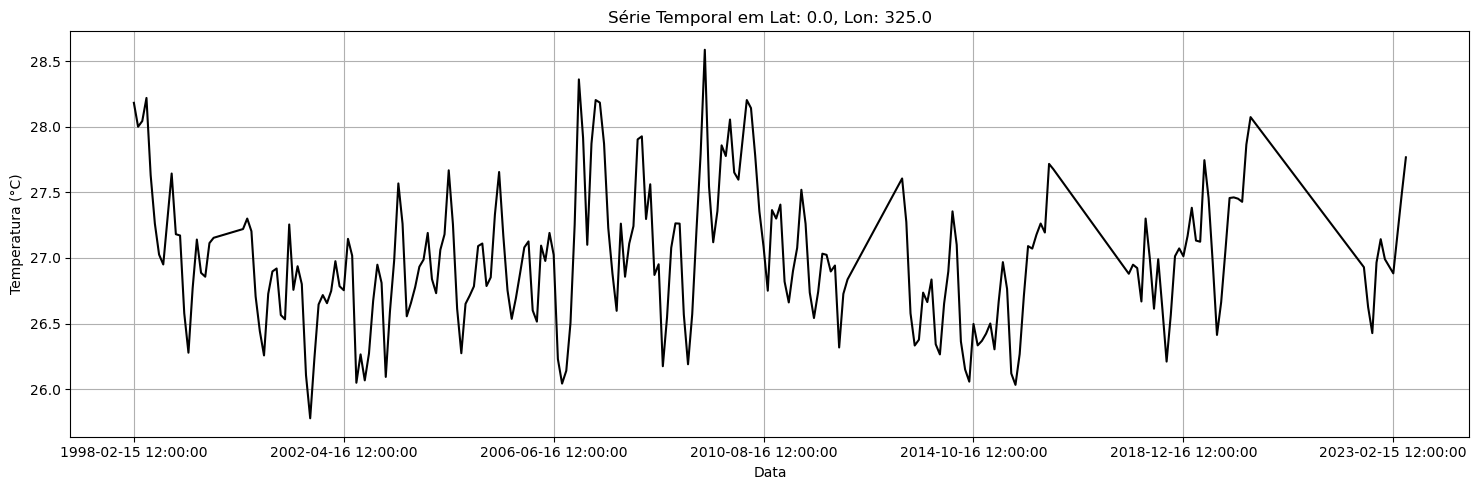

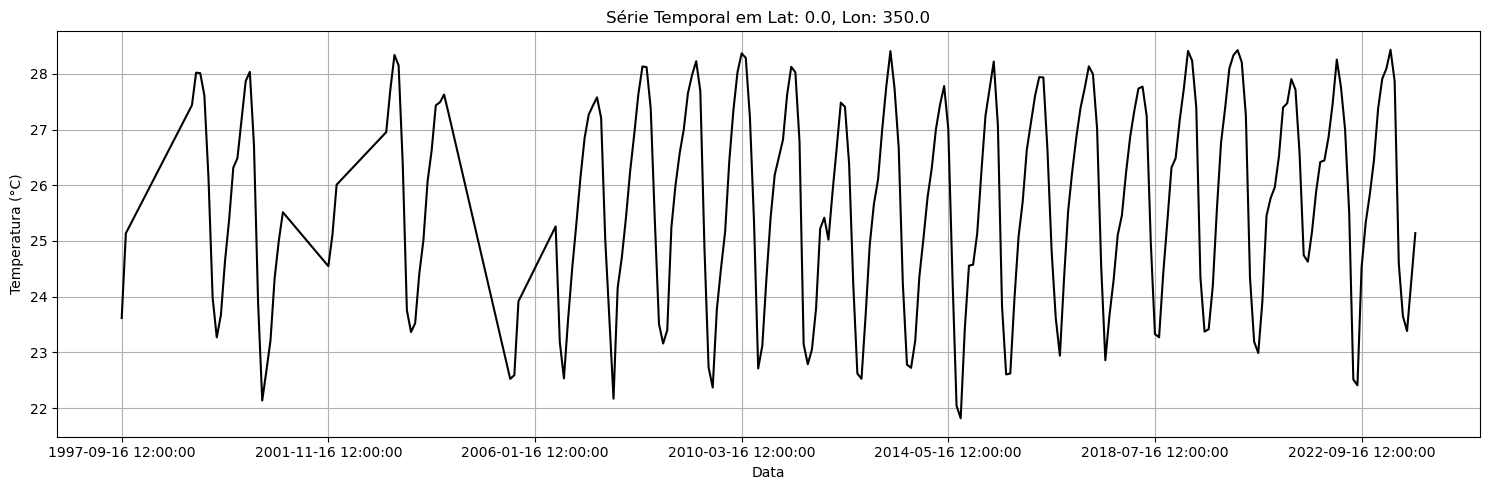

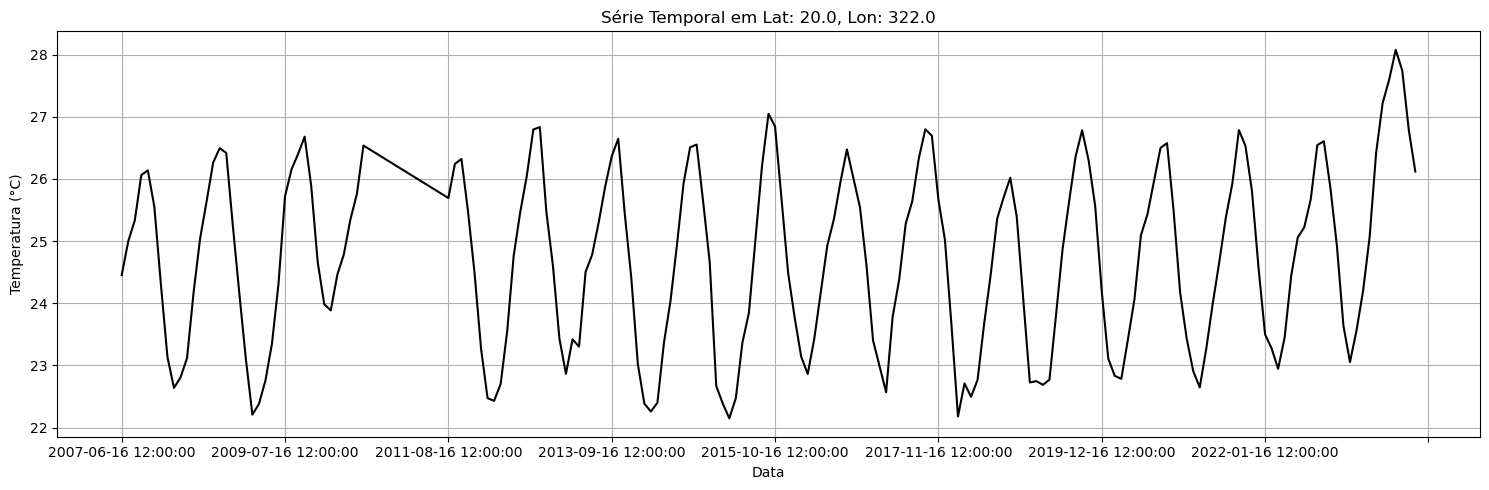

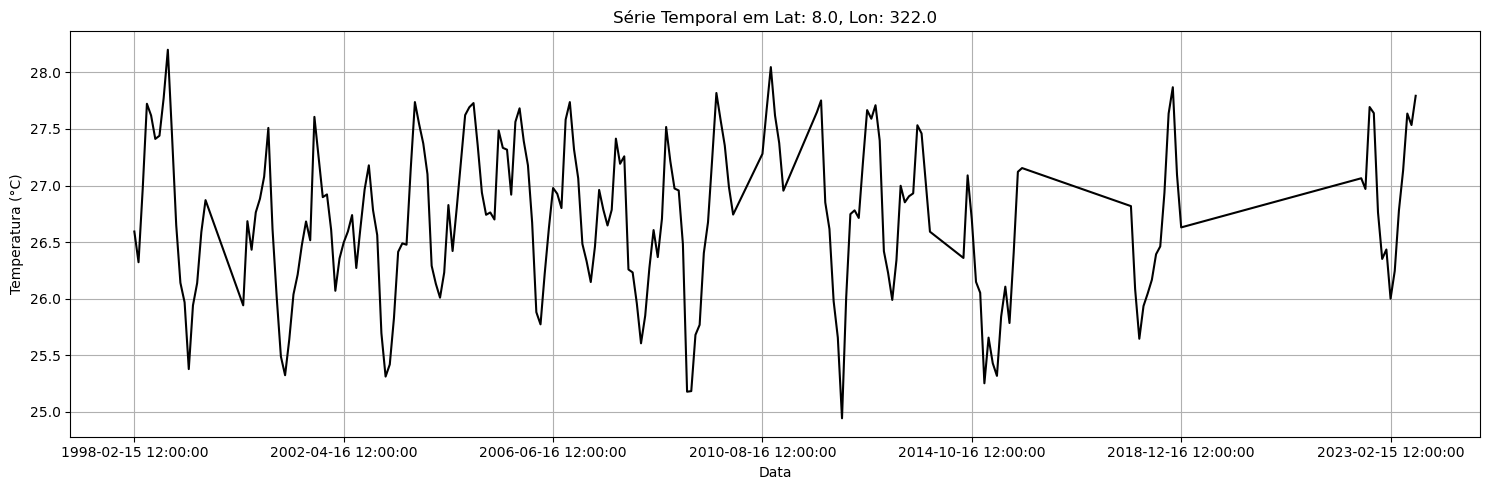

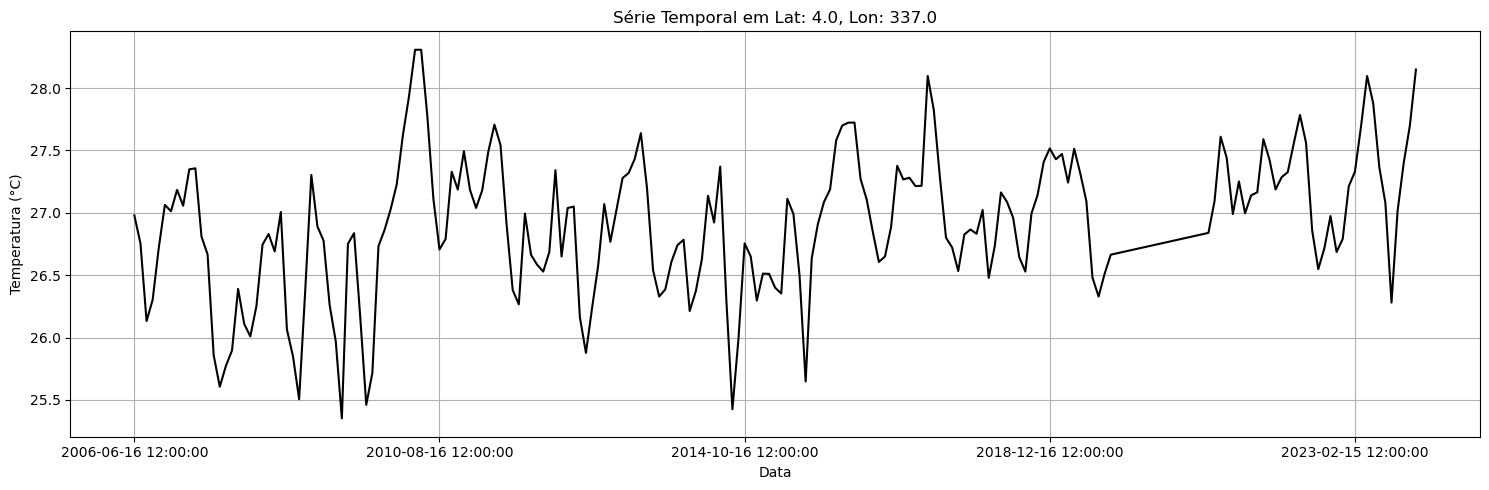

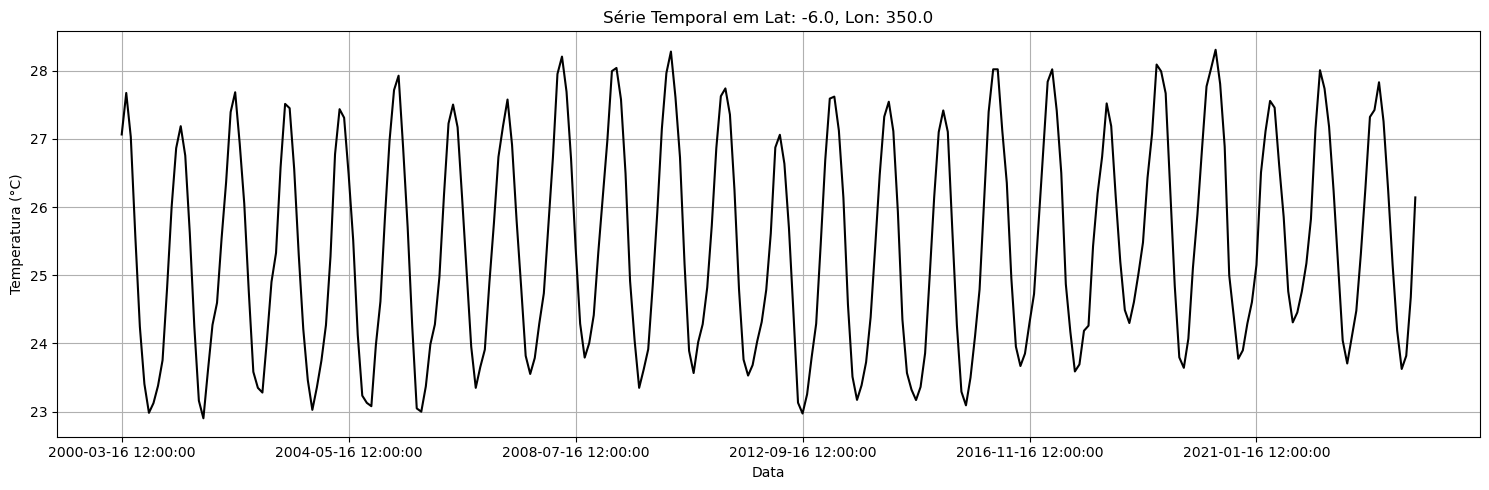

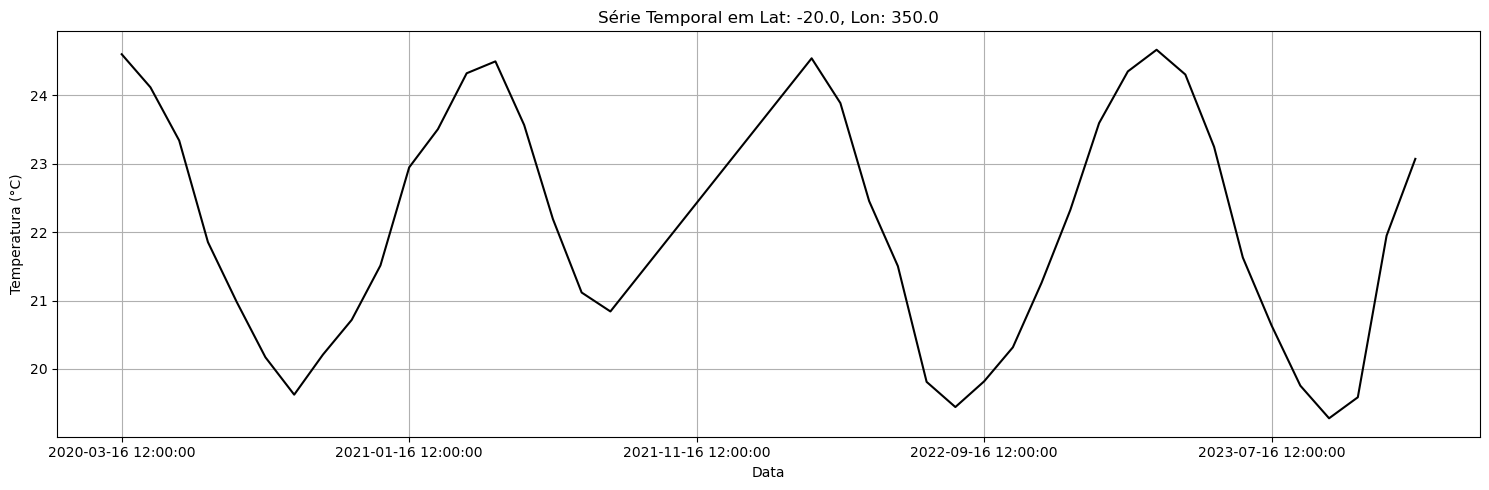

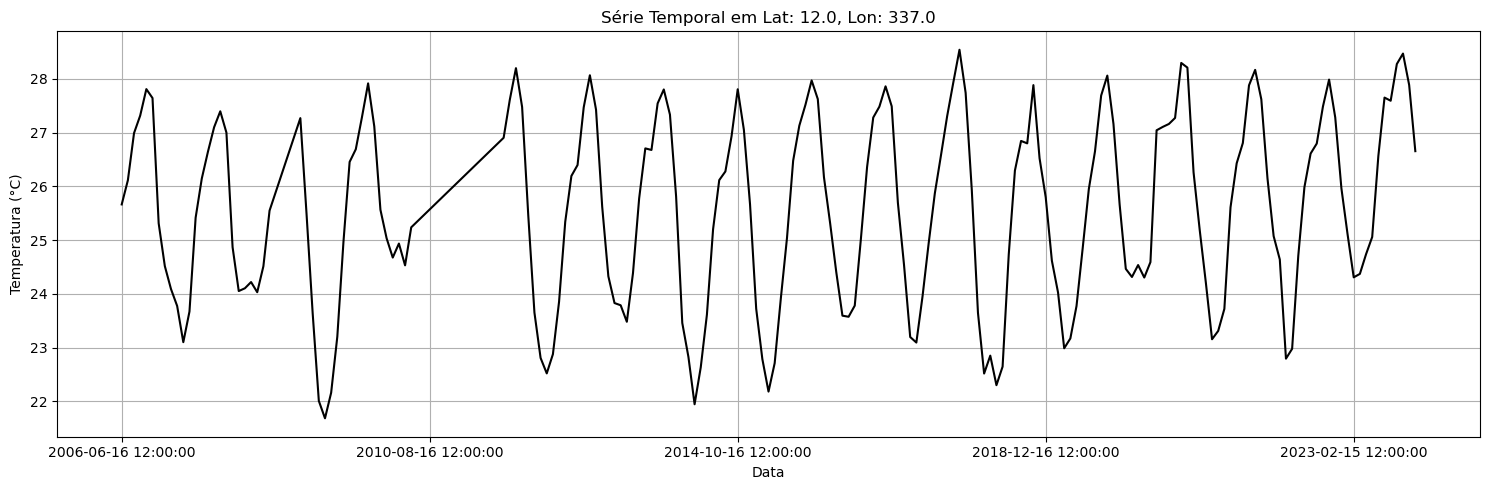

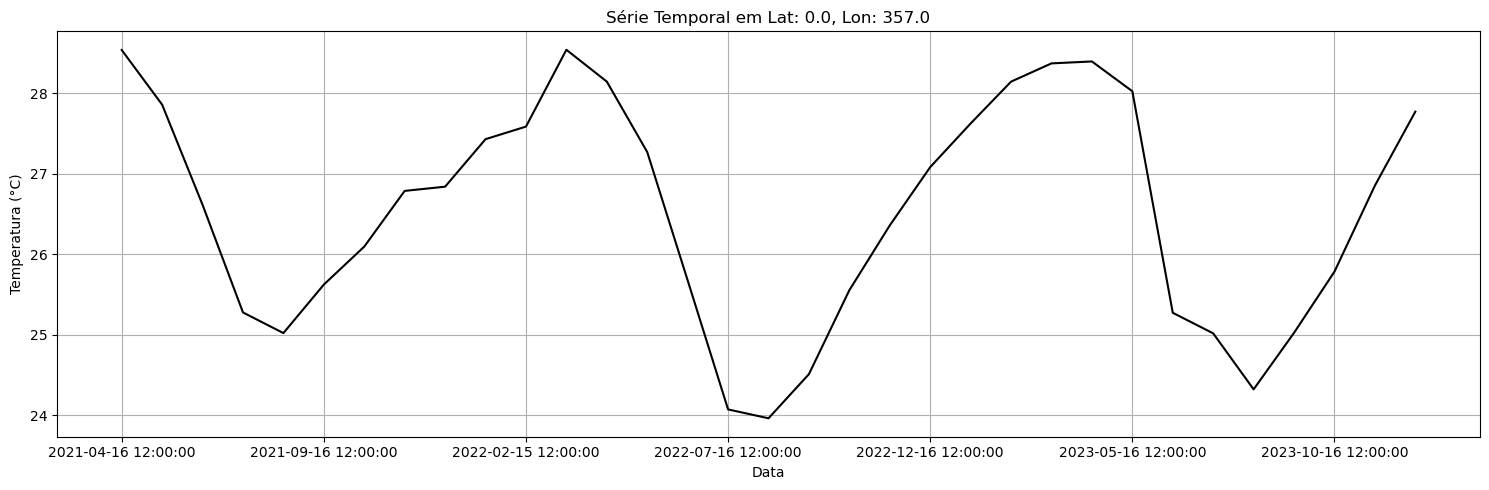

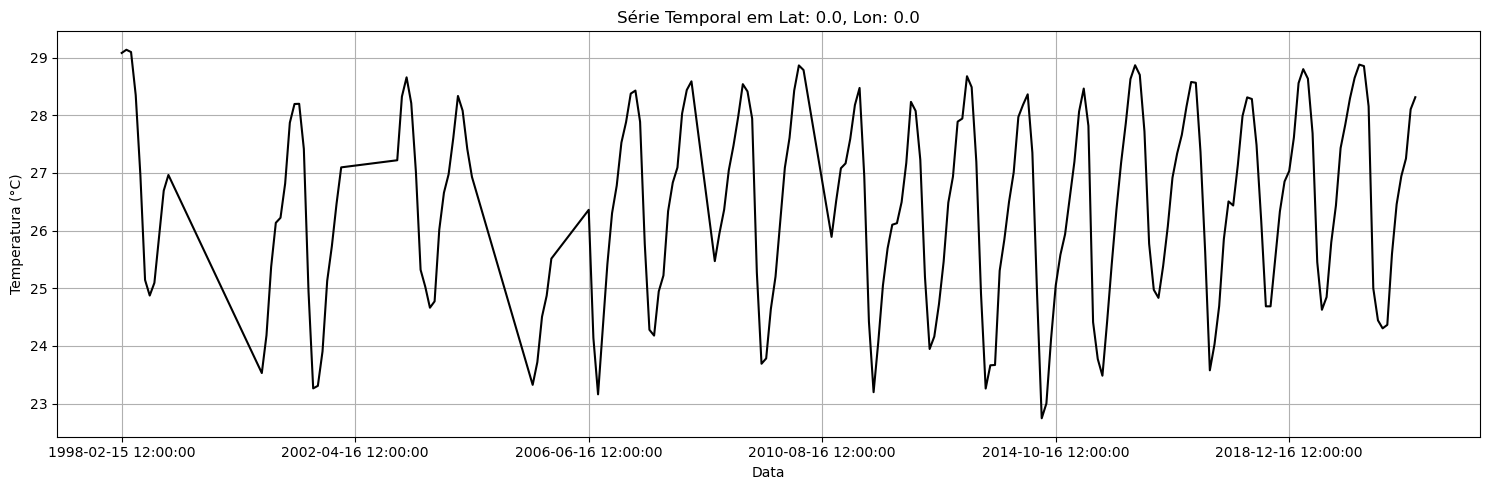

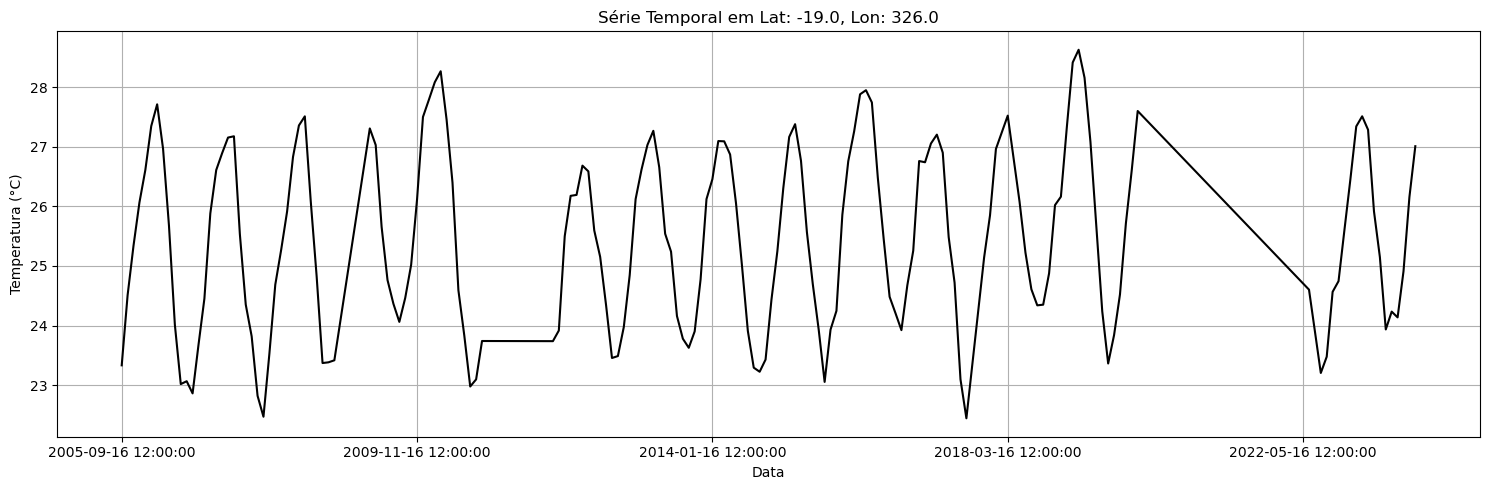

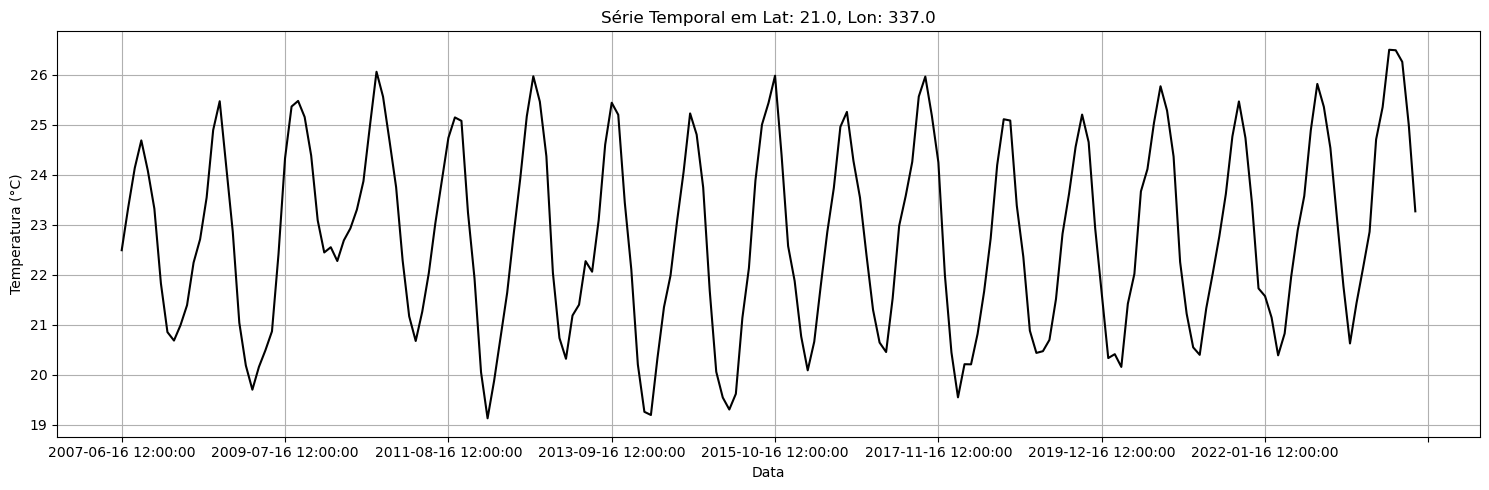

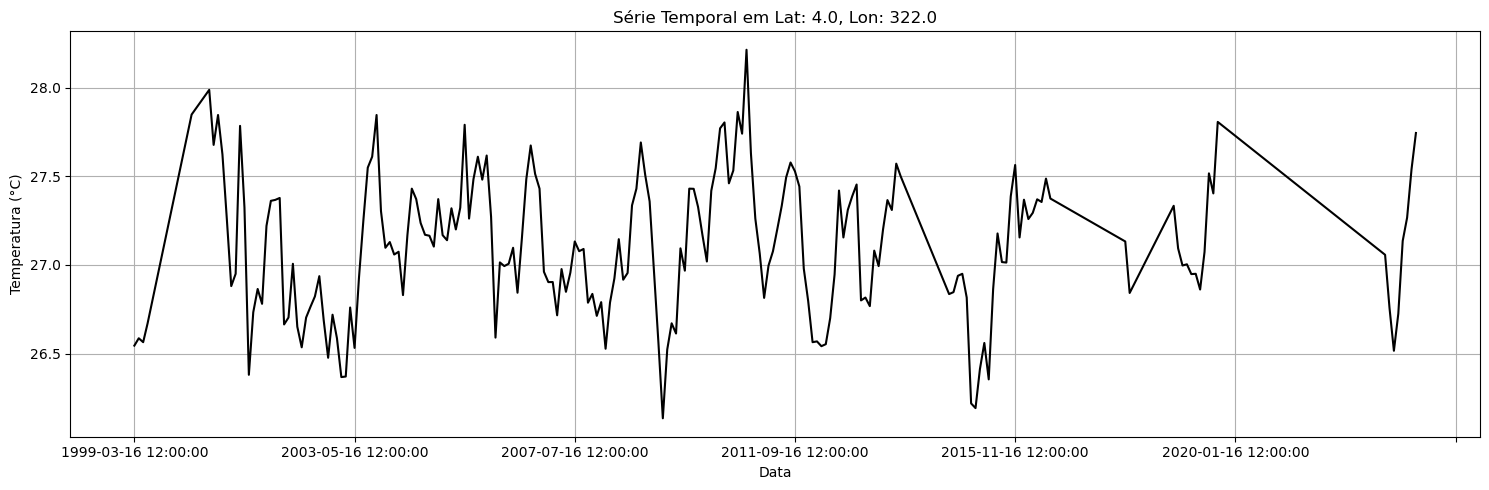

In [23]:
import pandas as pd

def ler_dados(arquivo):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base
    temperatura = ds.variables['AT_21'][:]
    
    fill_value = 1e35  
    temperatura = np.where(temperatura == fill_value, np.nan, temperatura)
    temperatura = temperatura.squeeze()  # Remove eixos de tamanho 1

    # Converte o tempo de unidades relativas (dias desde uma data) para objetos datetime
    datas = nc.num2date(tempo, units=ds.variables['time'].units)
    
    # Cria um DataFrame do pandas
    df = pd.DataFrame({
        'Data': datas,
        'Temperatura': temperatura
    })
    
    # Define a coluna de data como o índice do DataFrame
    df.set_index('Data', inplace=True)
    
    # Interpolação linear dos dados de temperatura
    df['Temperatura_Interpolada'] = df['Temperatura'].interpolate(method='linear')
    
    return lat, lon, df

def plotar_serie_temporal(df, titulo):
    plt.figure(figsize=(15,5))

    # Utiliza os dados interpolados para plotar
    df['Temperatura_Interpolada'].plot(color='k', xlabel='Data', ylabel='Temperatura (°C)')
    
    plt.title(titulo)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/AirT/*.cdf"

arquivos_netCDF = glob.glob(caminho_pasta)

for arquivo in arquivos_netCDF:
    lat, lon, df = ler_dados(arquivo)
    titulo = f"Série Temporal em Lat: {lat.mean():.1f}, Lon: {lon.mean():.1f}"
    plotar_serie_temporal(df, titulo)


# Preenchimento método fill

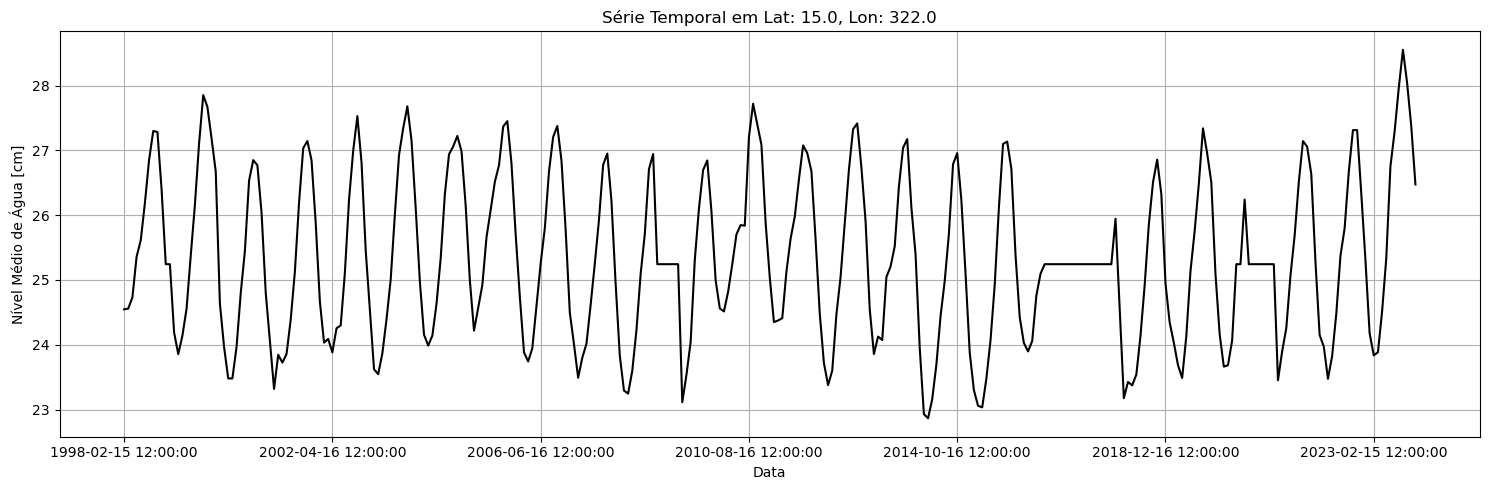

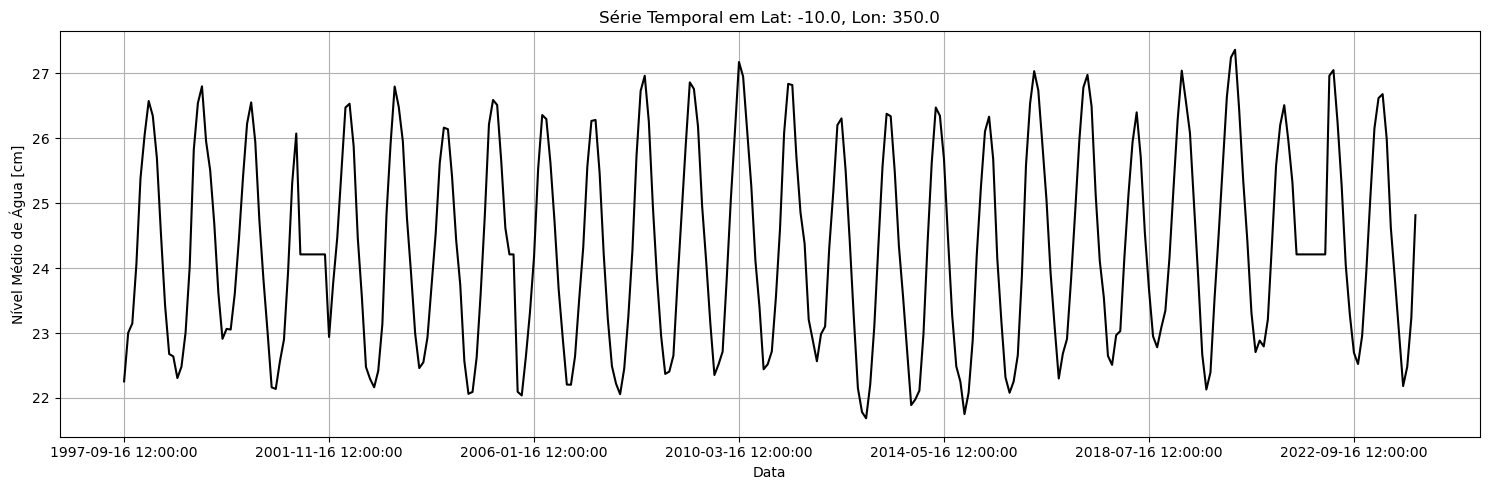

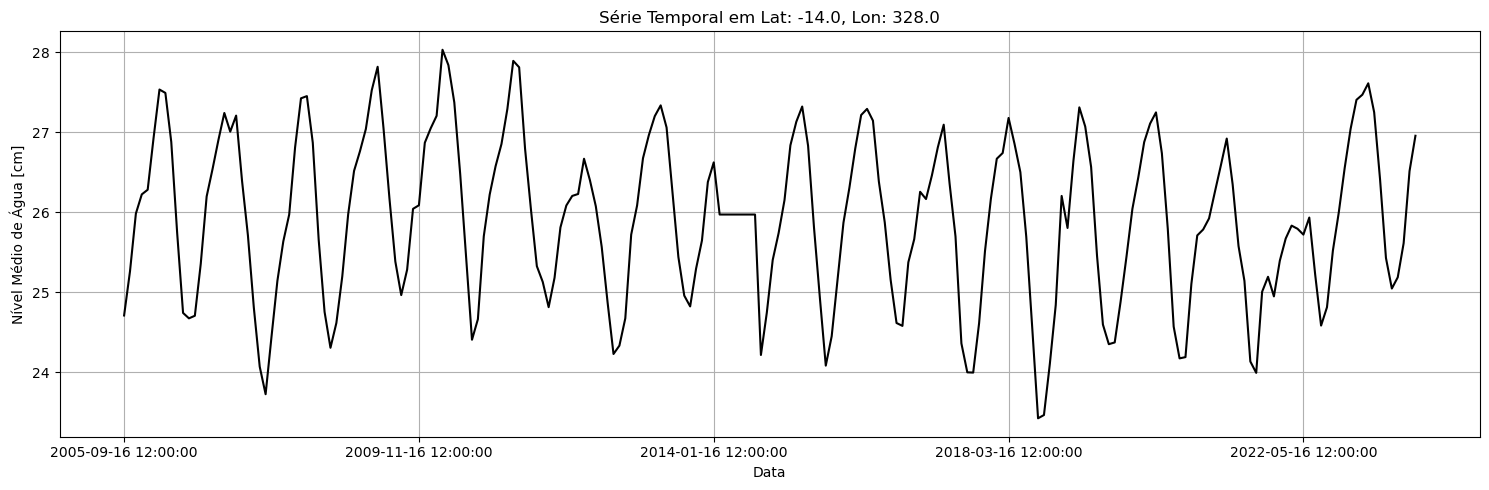

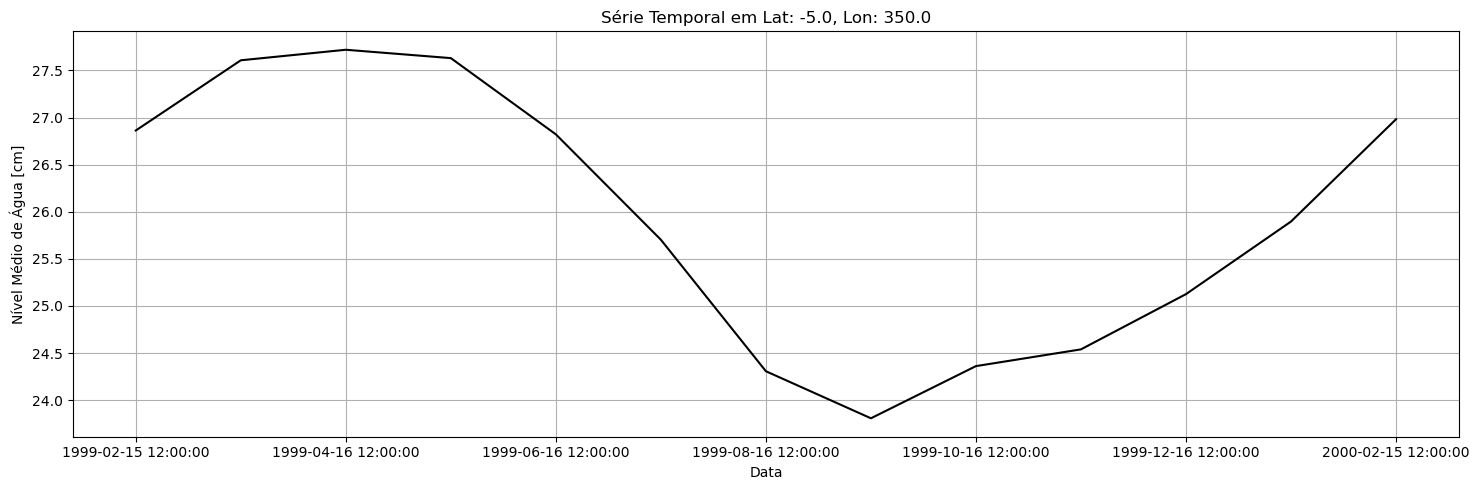

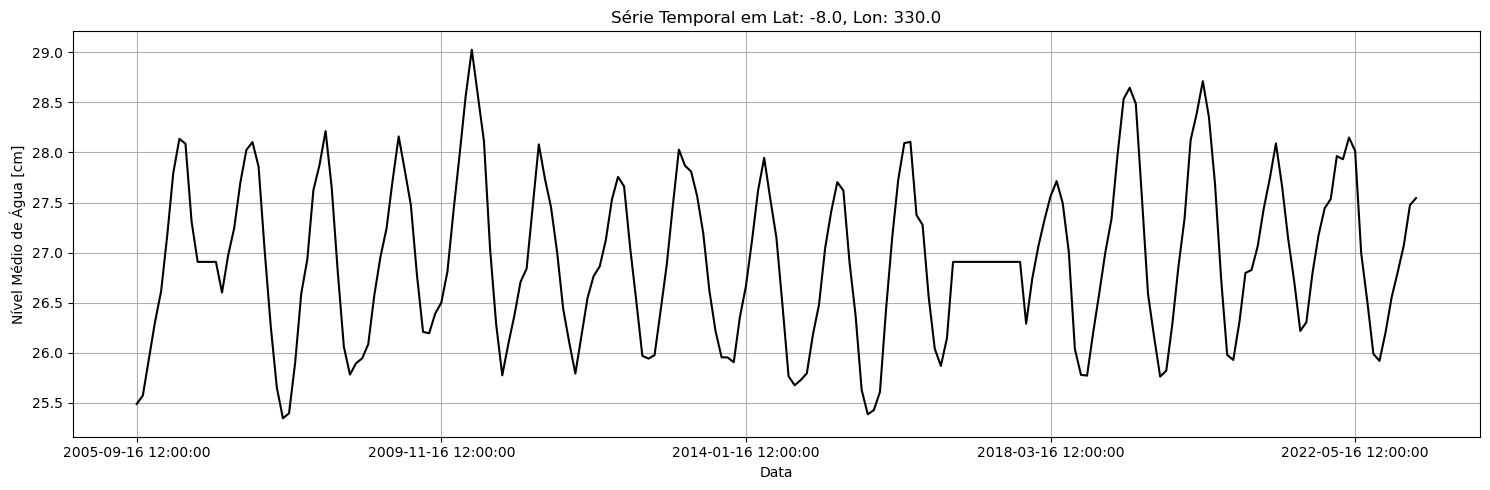

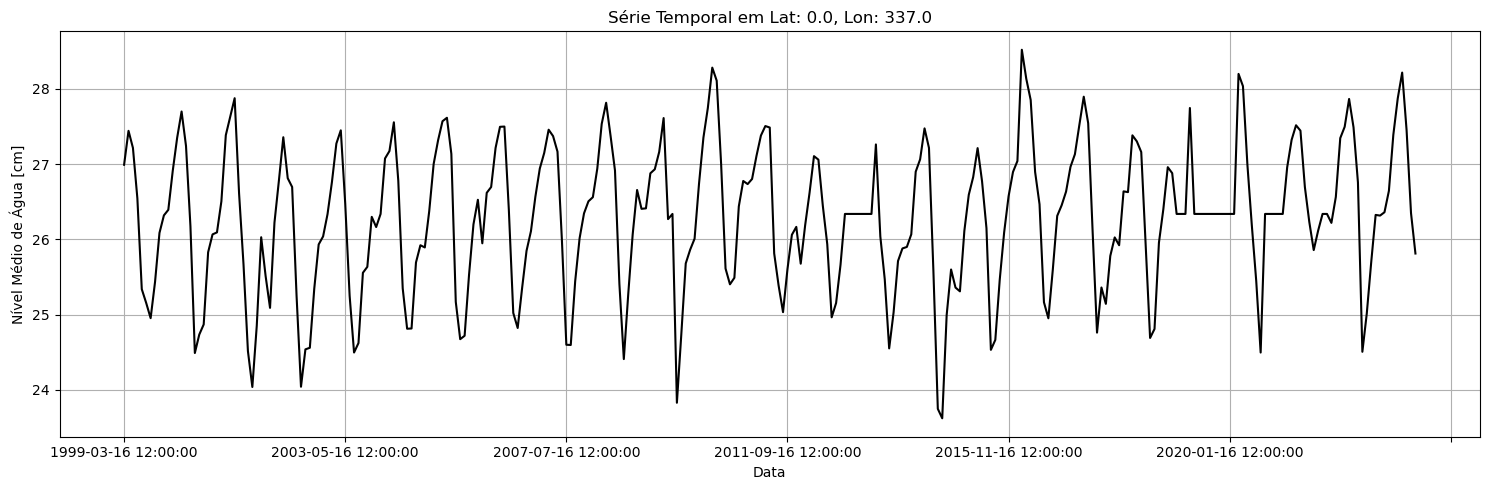

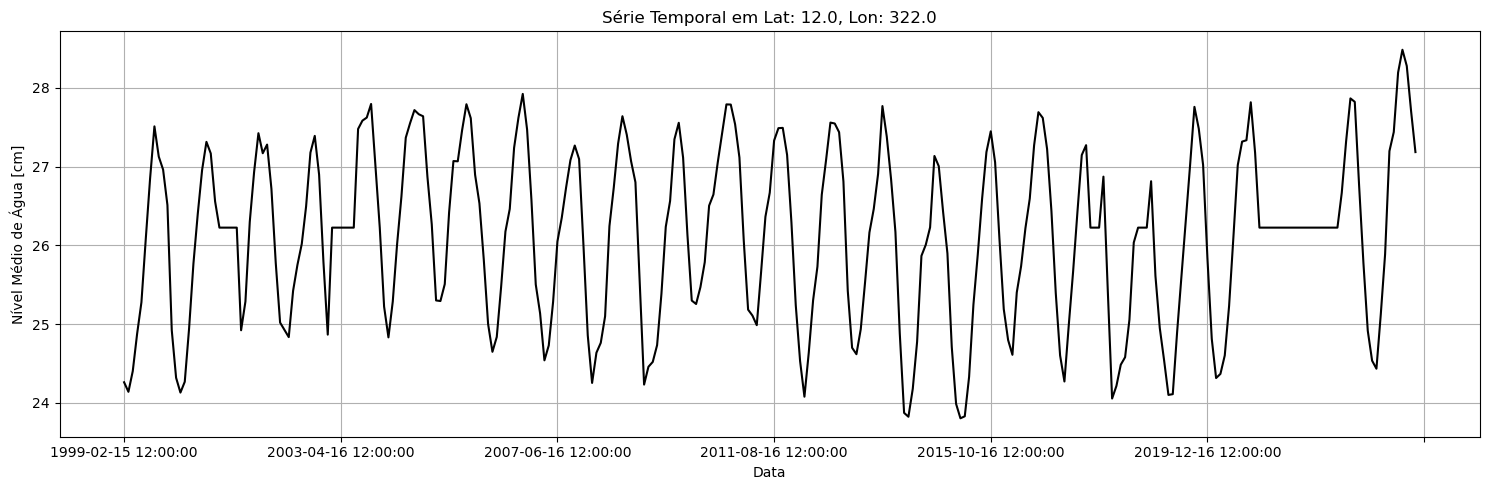

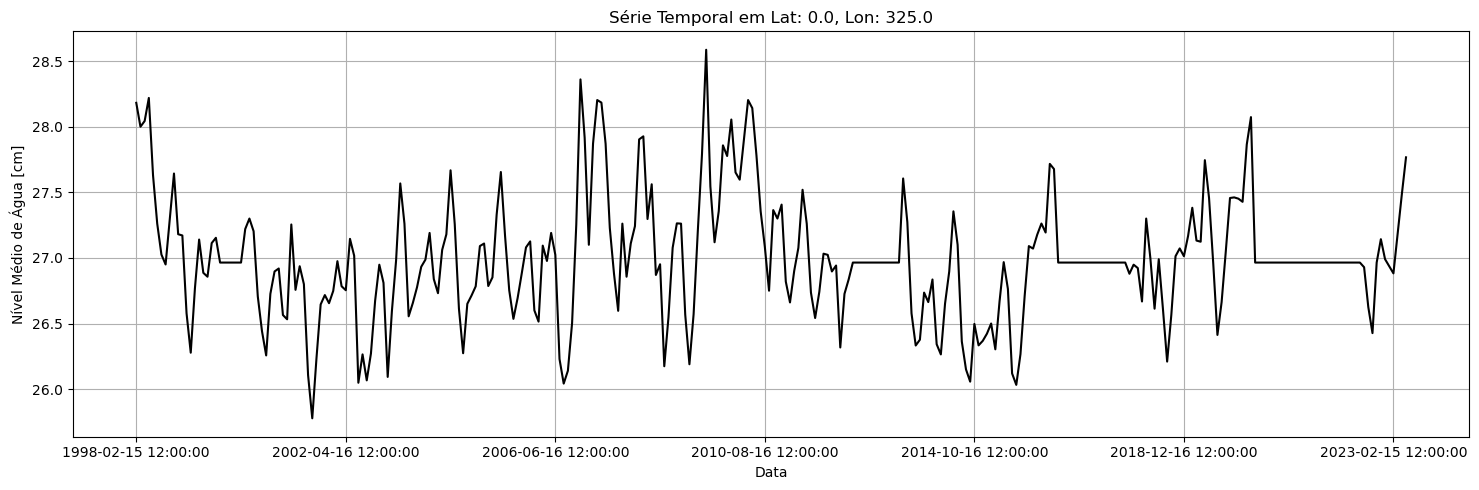

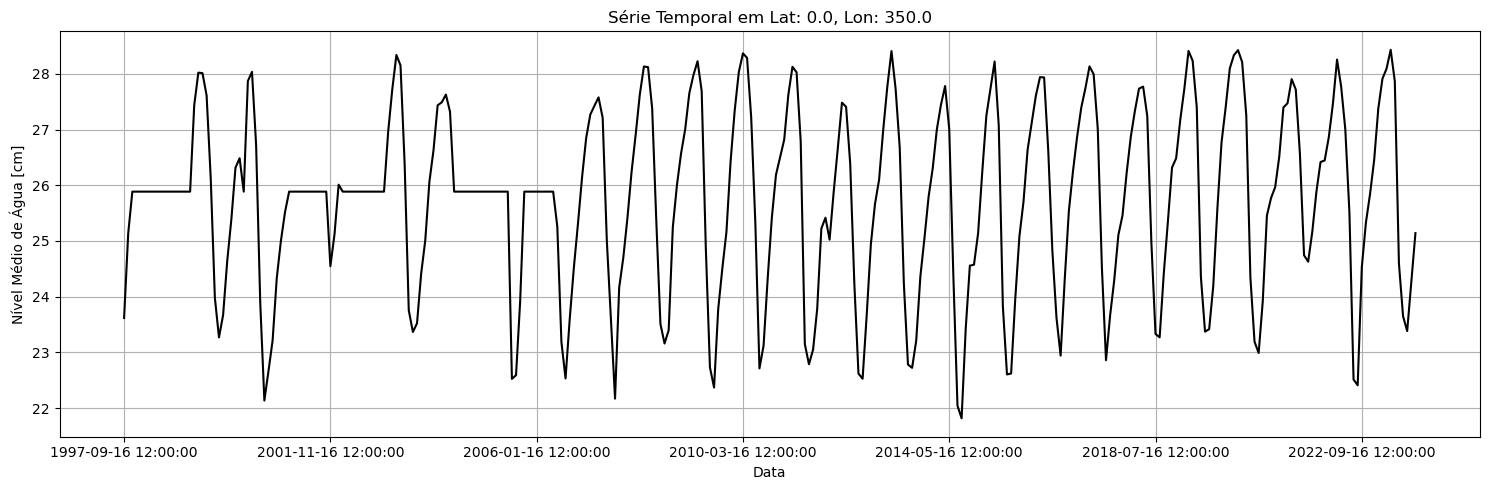

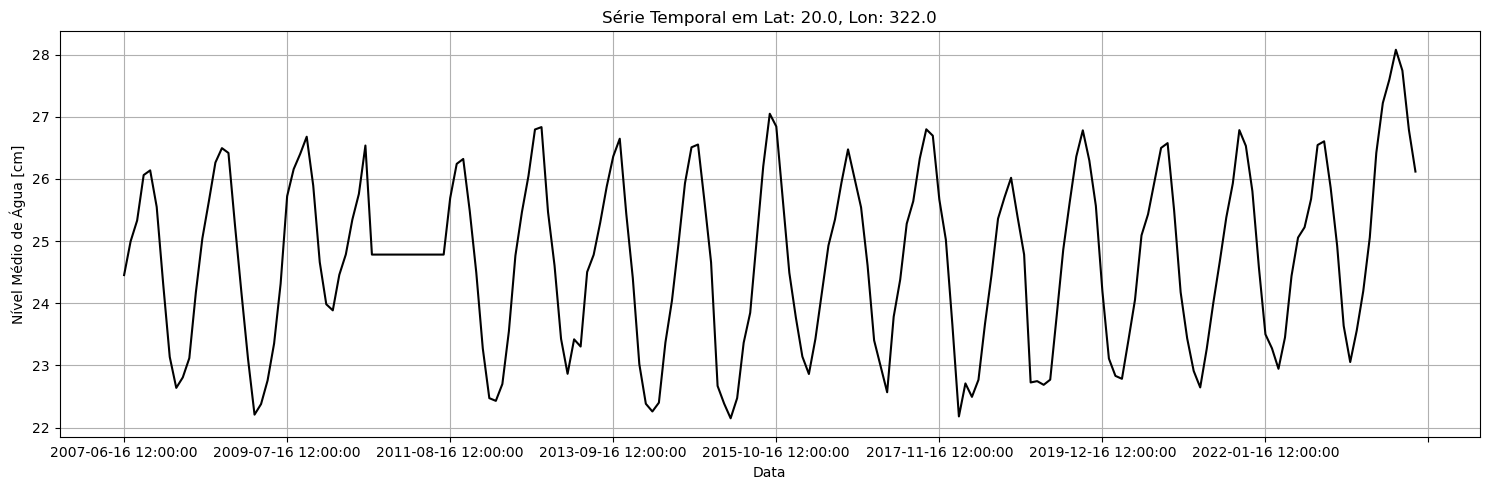

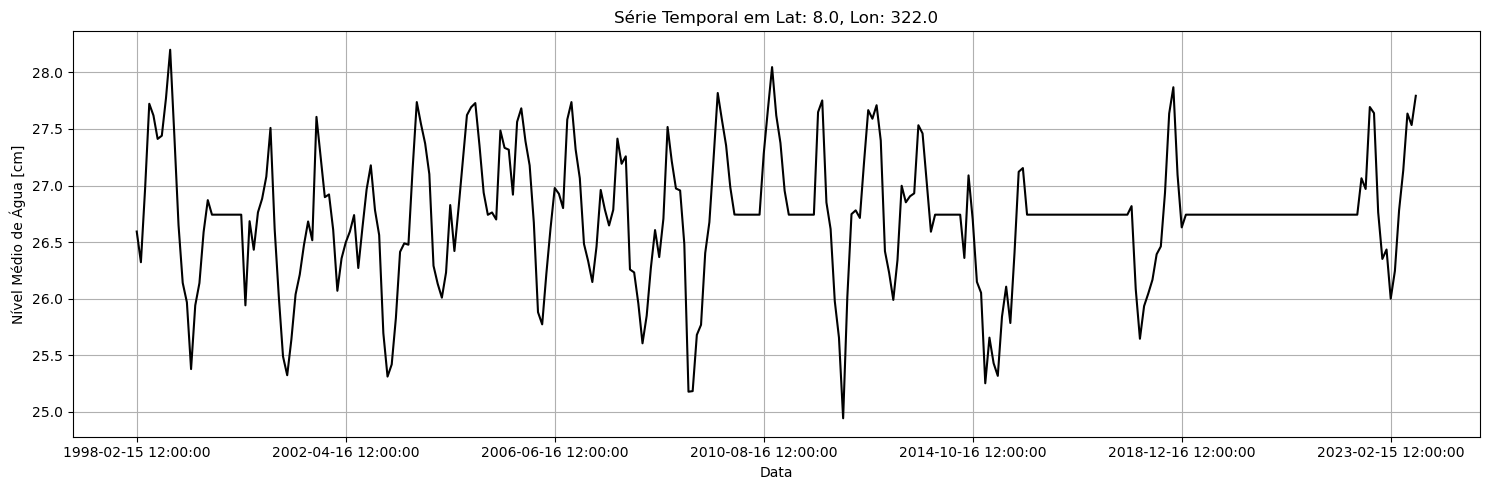

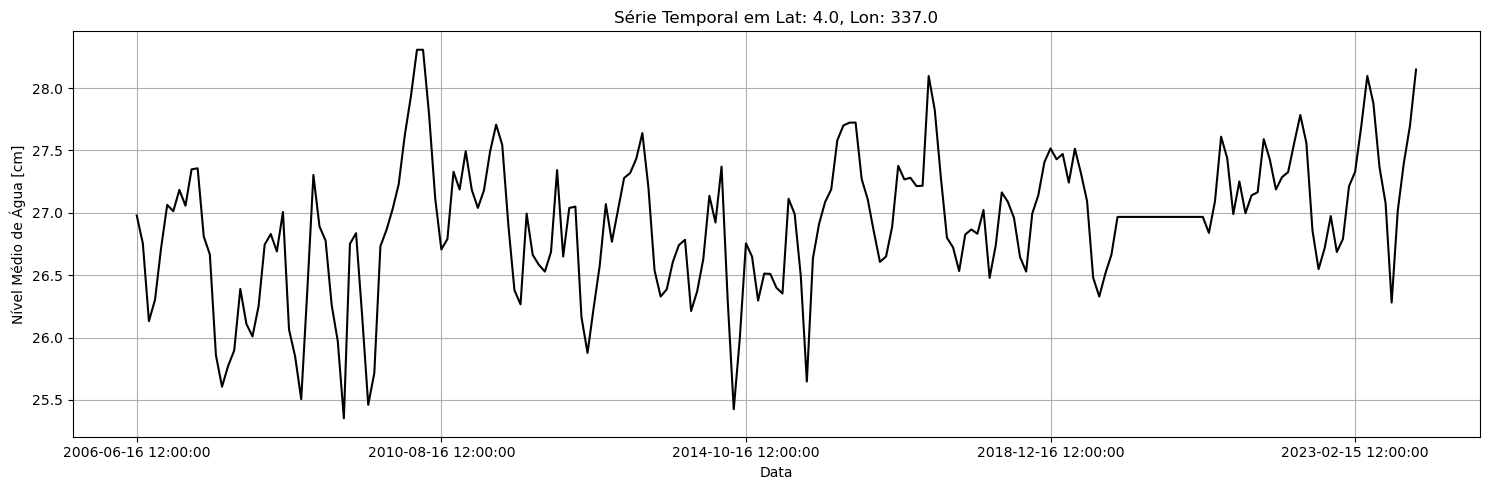

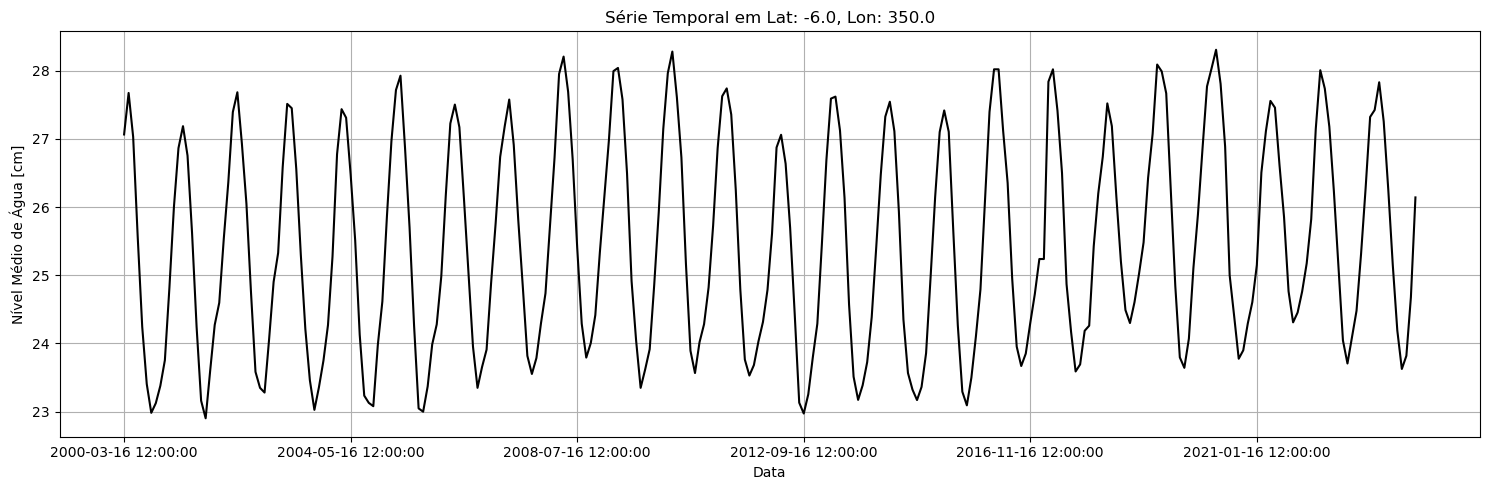

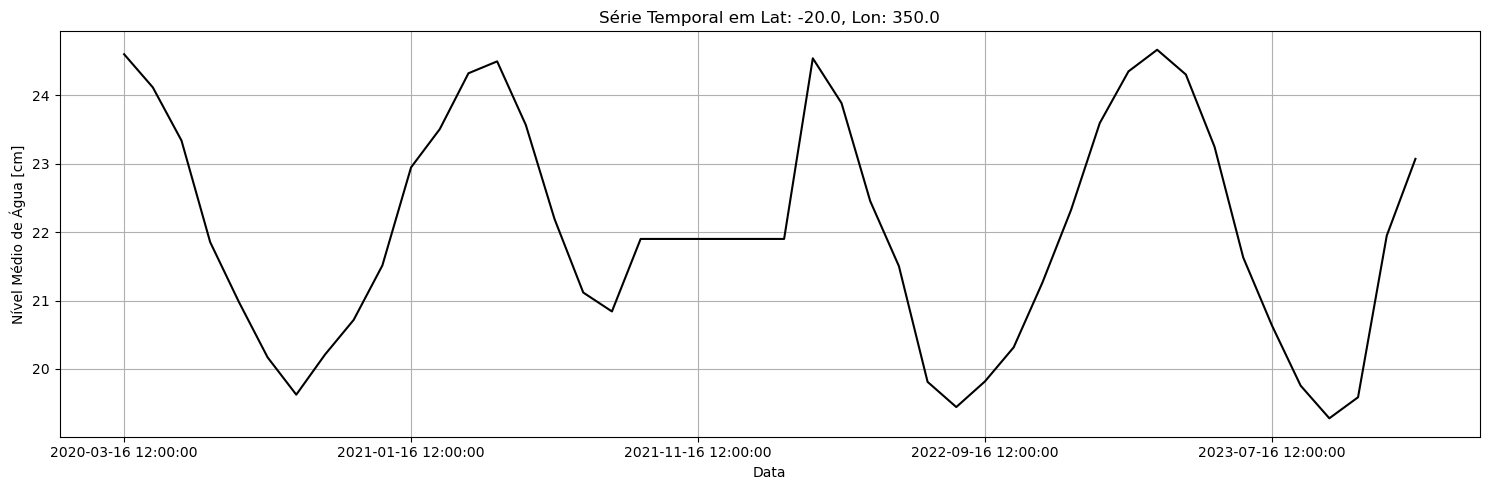

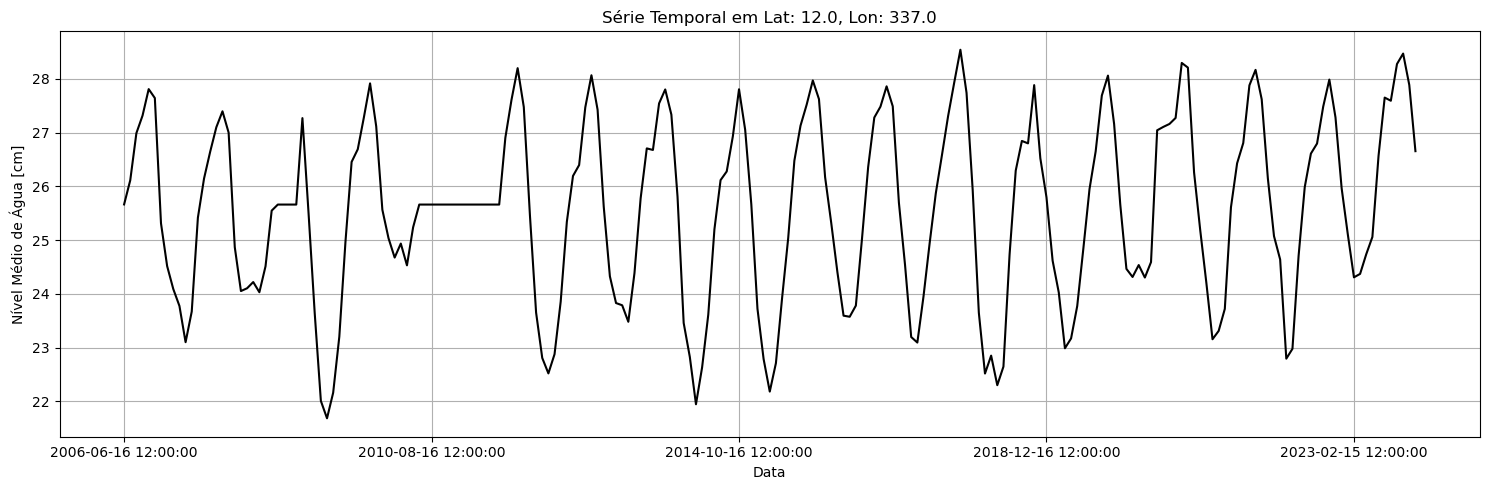

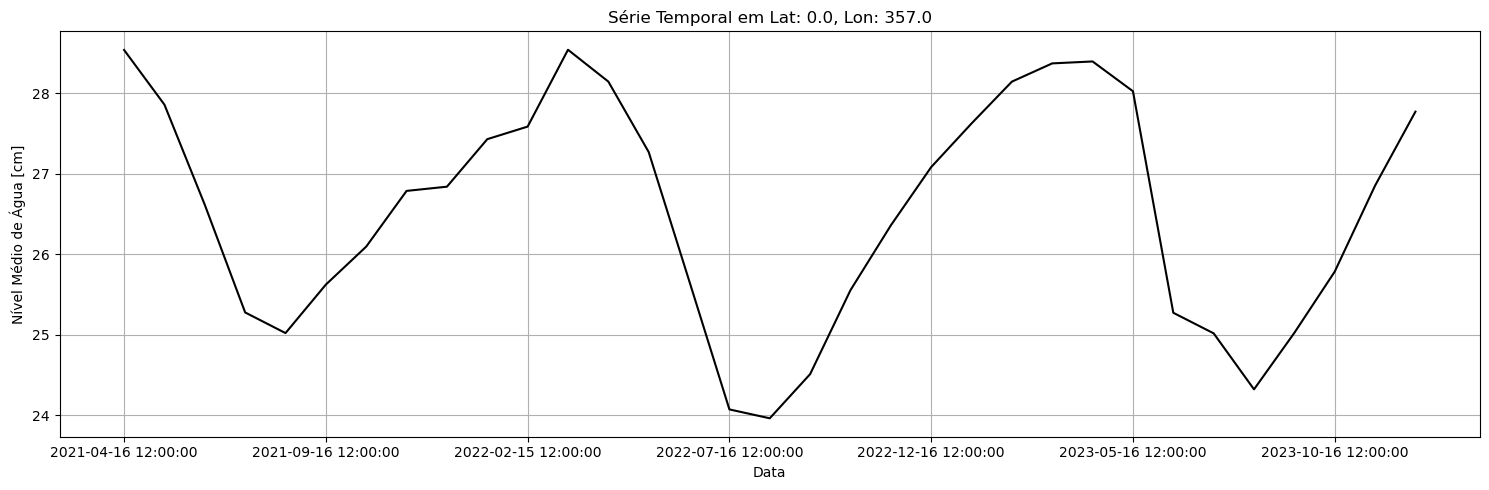

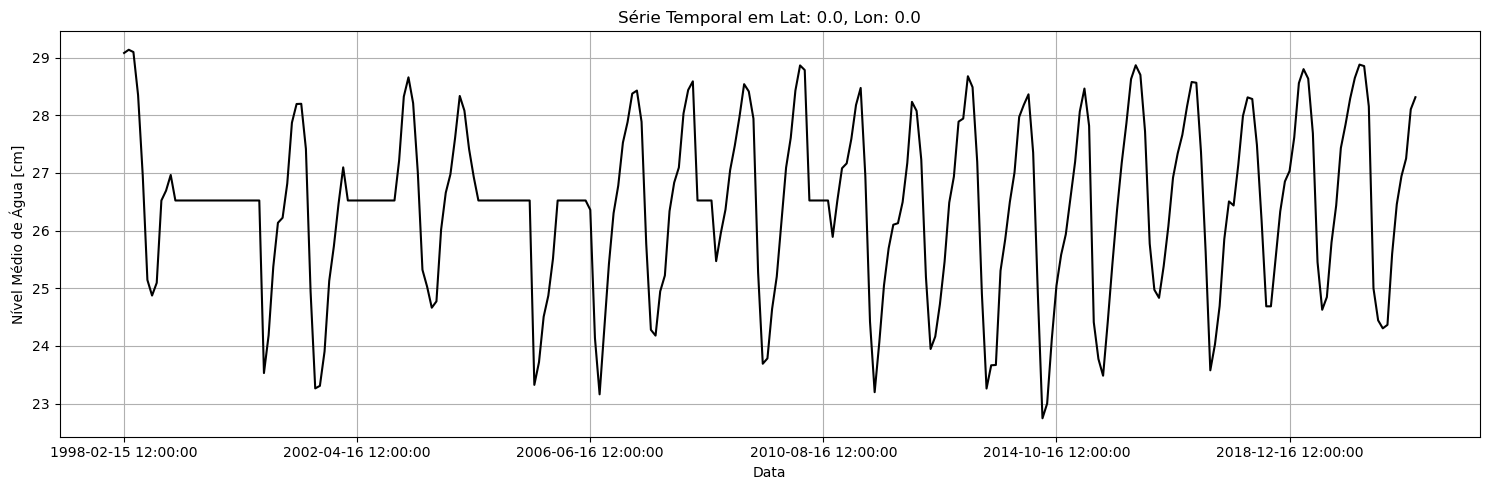

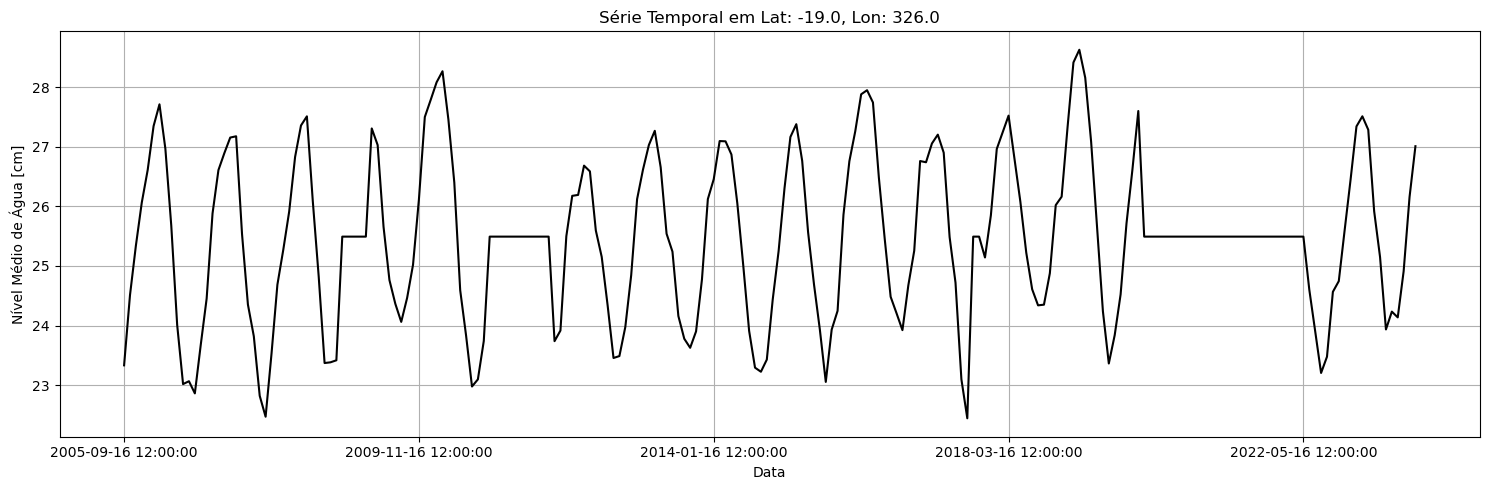

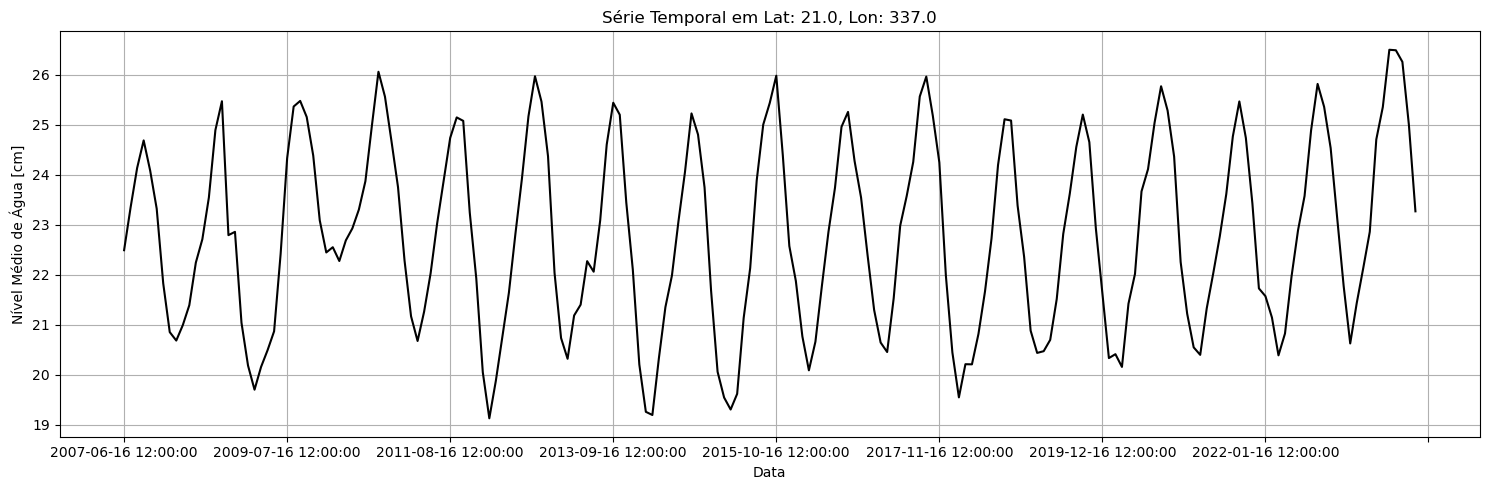

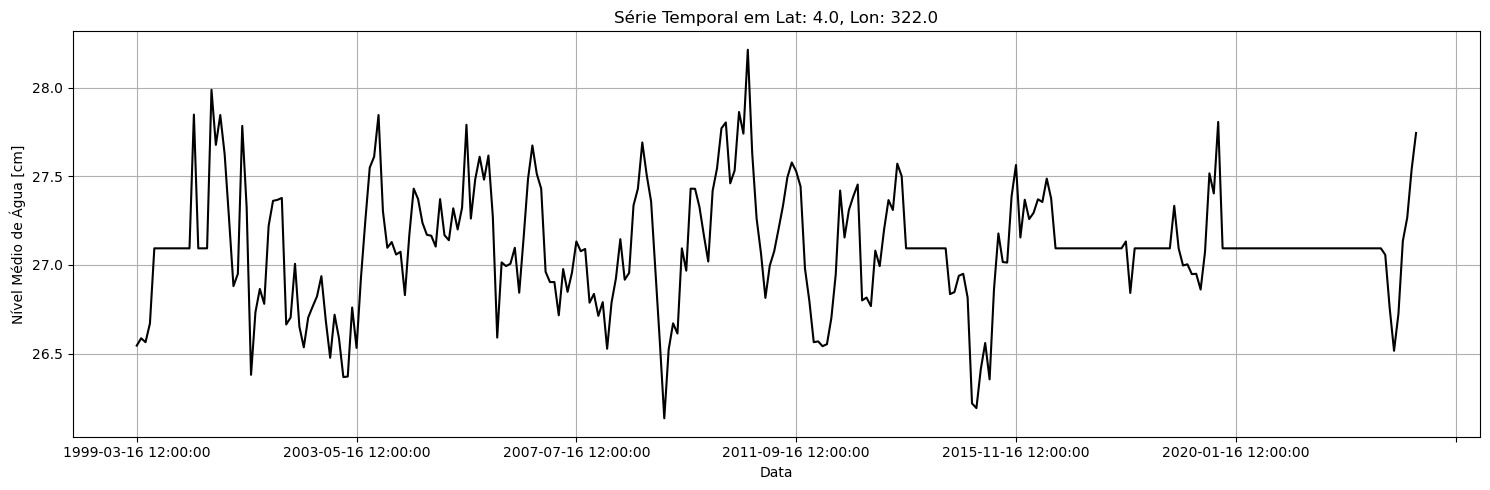

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import glob
import datetime
import matplotlib.dates as mdates

def ler_dados(arquivo):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]
    dados_variavel = ds.variables['AT_21'][:]  # Ajuste para o nome correto da variável

    fill_value = 1e35
    dados_variavel = np.where(dados_variavel == fill_value, np.nan, dados_variavel)
    dados_variavel = dados_variavel.squeeze()

    datas = nc.num2date(tempo, units=ds.variables['time'].units)

    df = pd.DataFrame({
        'Data': datas,
        'DadosVariavel': dados_variavel
    })
    
    df.set_index('Data', inplace=True)
    
    # Preenchimento por média
    mean_value = df['DadosVariavel'].median()
    df['DadosVariavel_Media'] = df['DadosVariavel'].fillna(mean_value)
    
    return lat, lon, df

def plotar_serie_temporal(df, titulo):
    plt.figure(figsize=(15,5))
    df['DadosVariavel_Media'].plot(color='k', xlabel='Data', ylabel='Nível Médio de Água [cm]')
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/AirT/*.cdf"

arquivos_netCDF = glob.glob(caminho_pasta)

for arquivo in arquivos_netCDF:
    lat, lon, df = ler_dados(arquivo)
    titulo = f"Série Temporal em Lat: {lat.mean():.1f}, Lon: {lon.mean():.1f}"
    plotar_serie_temporal(df, titulo)


# Preenchimento TSM 

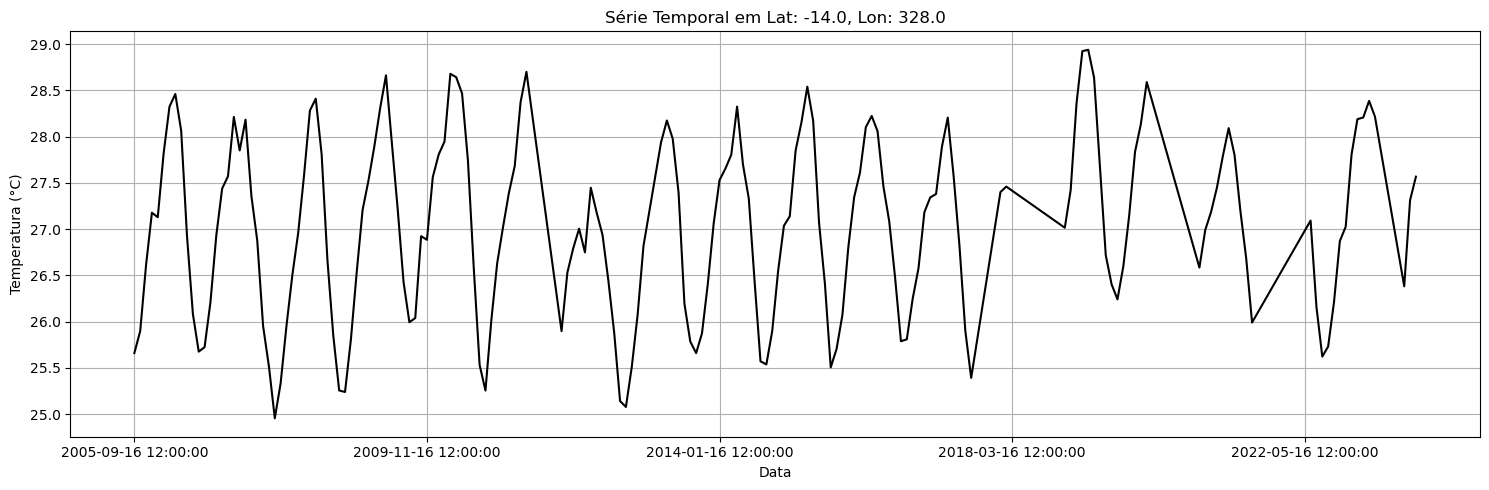

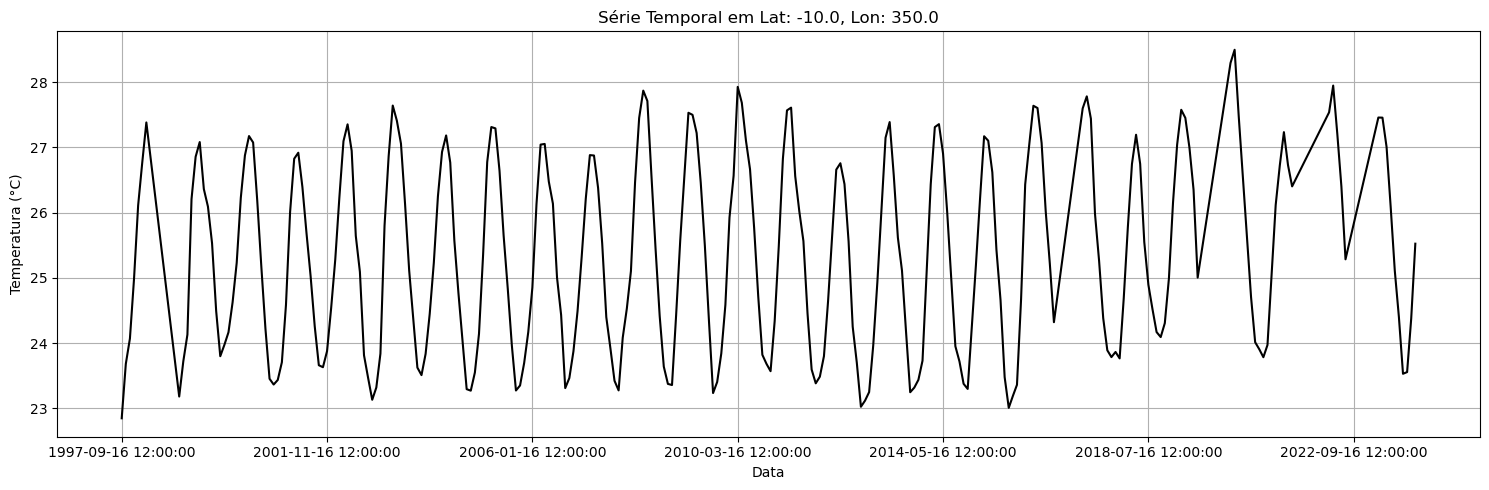

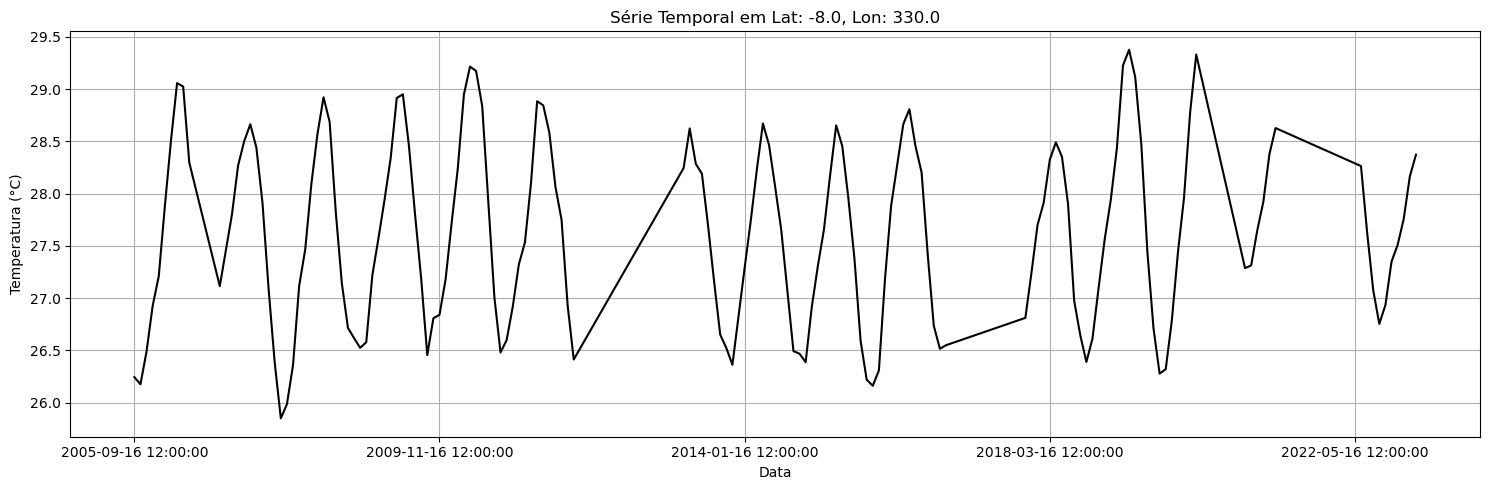

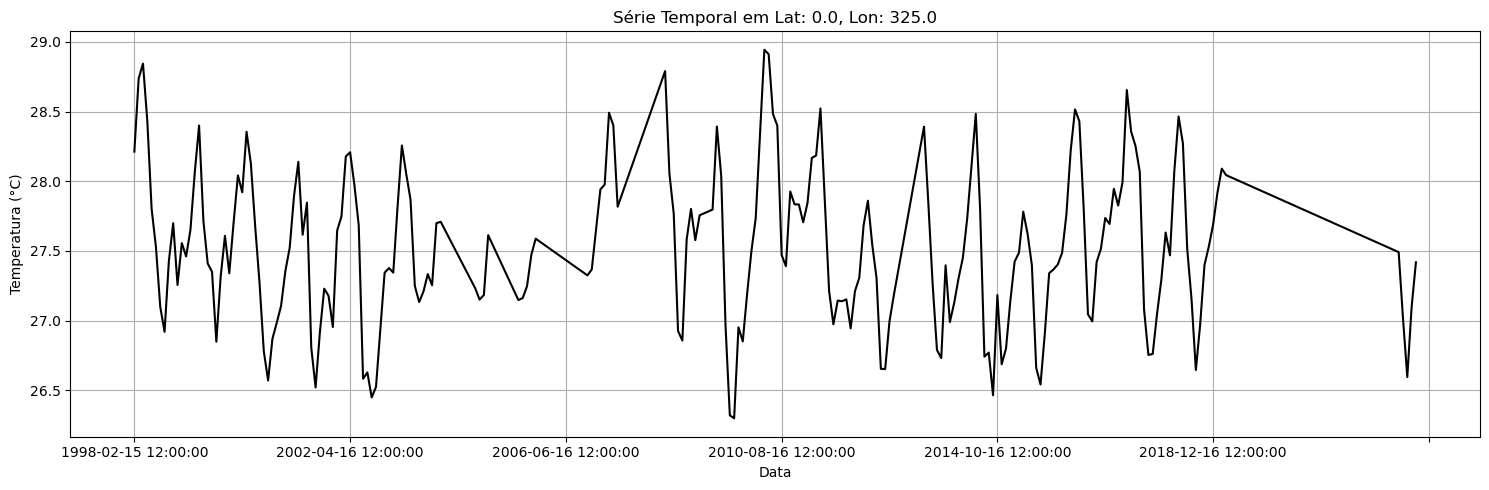

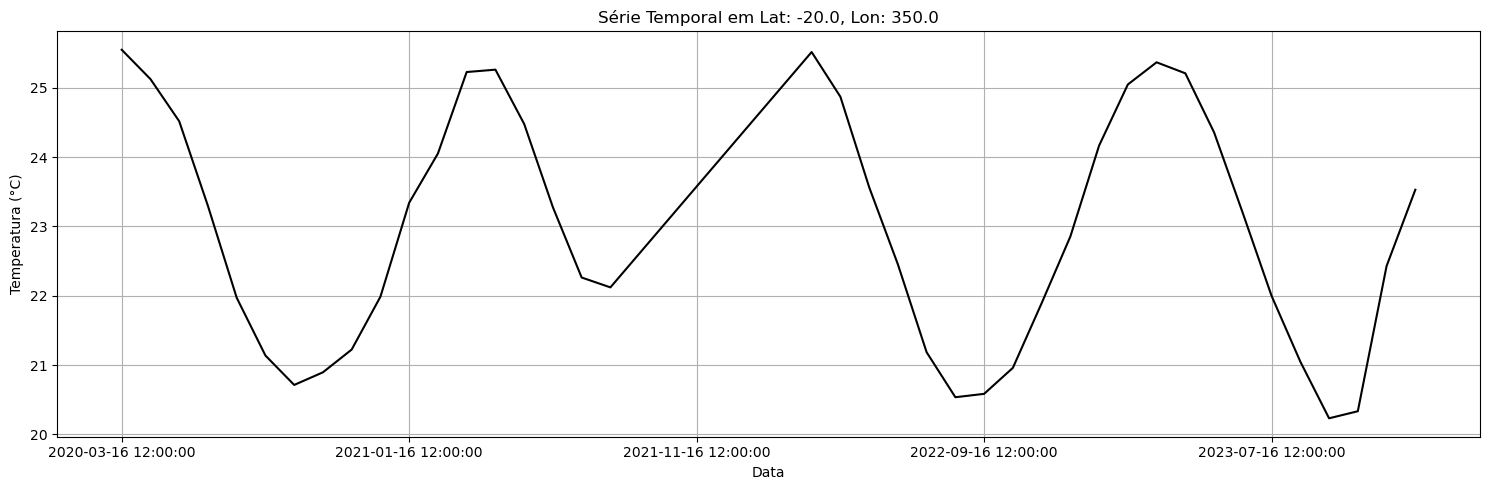

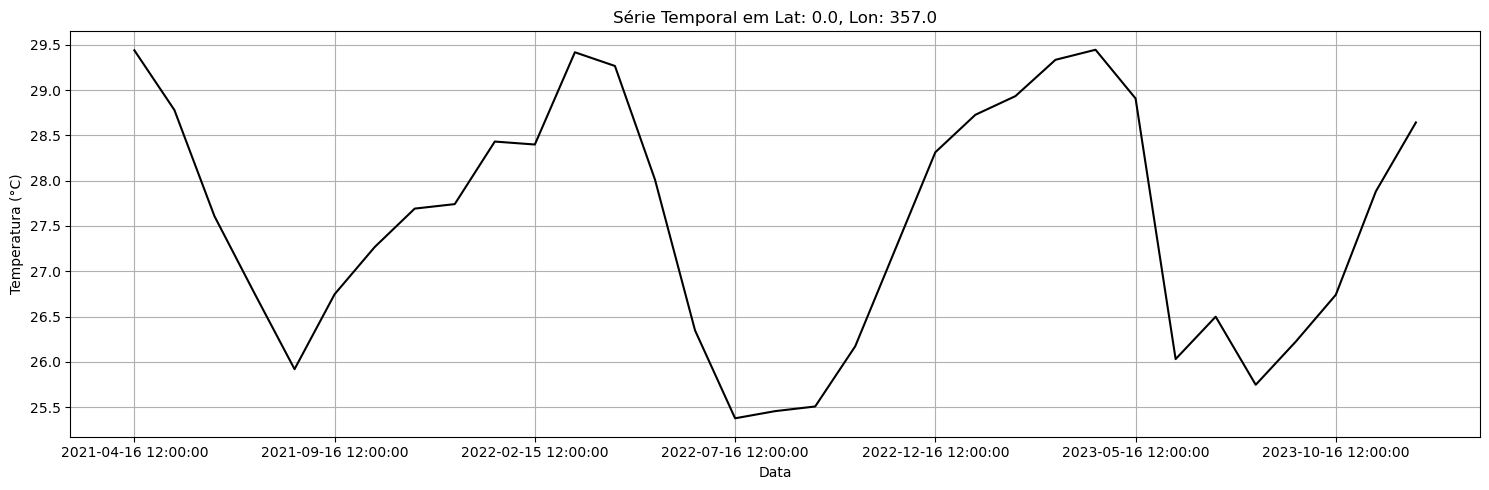

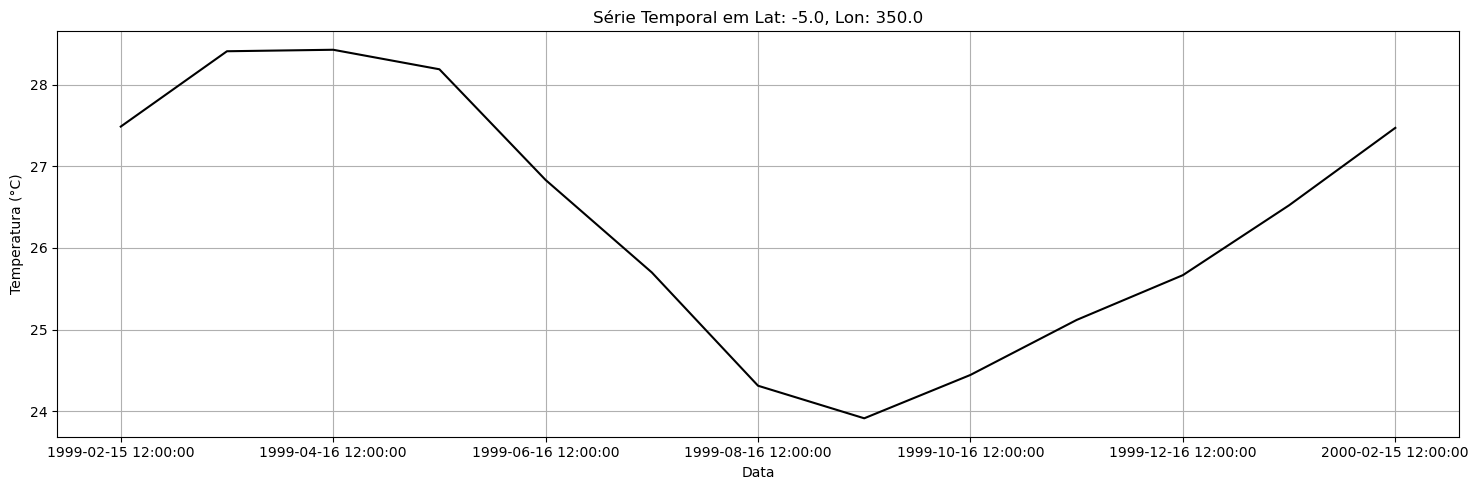

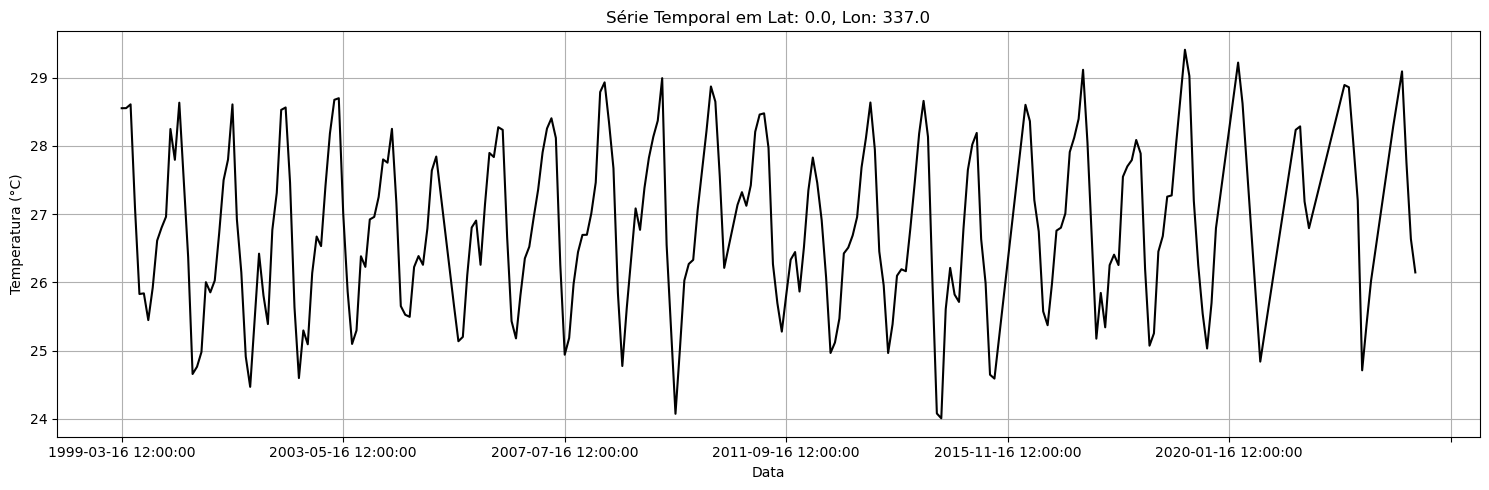

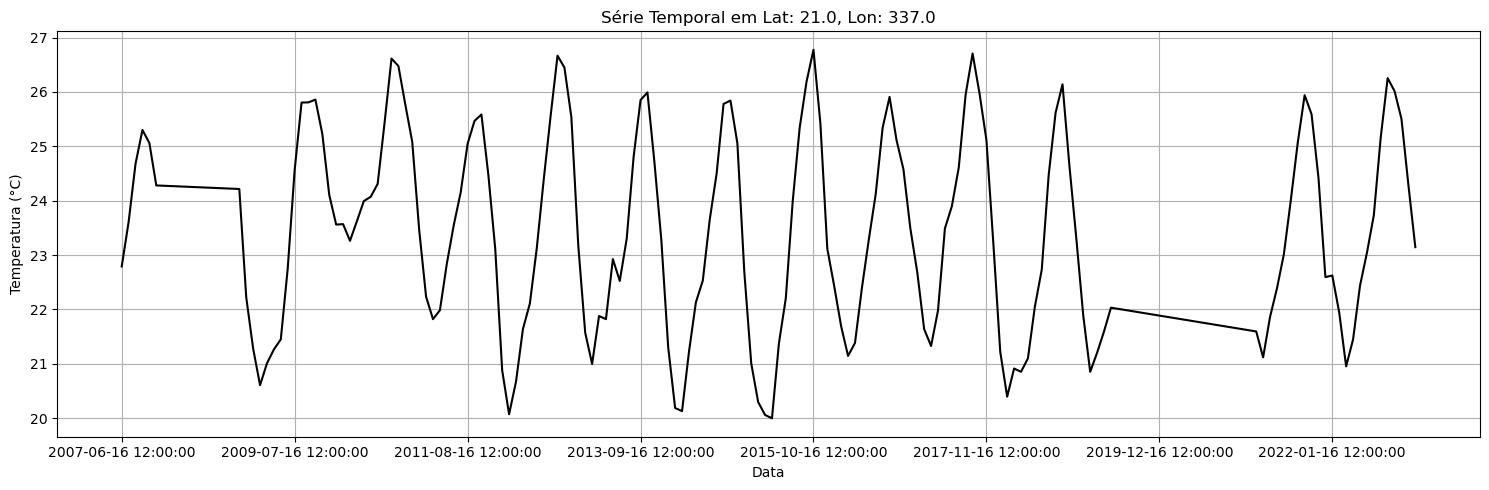

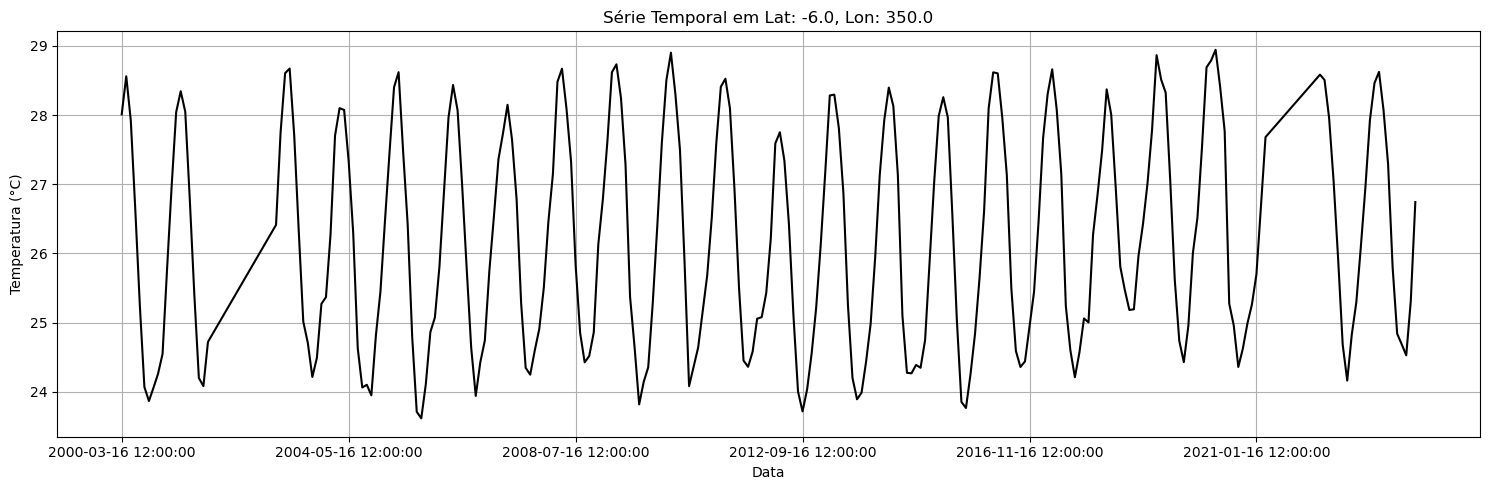

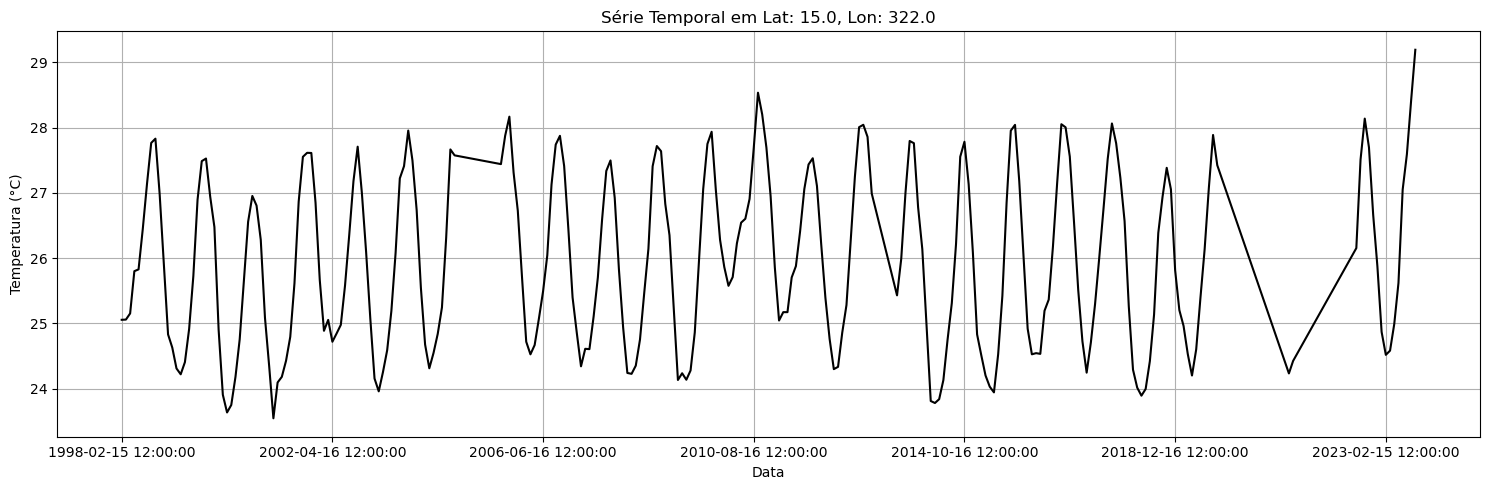

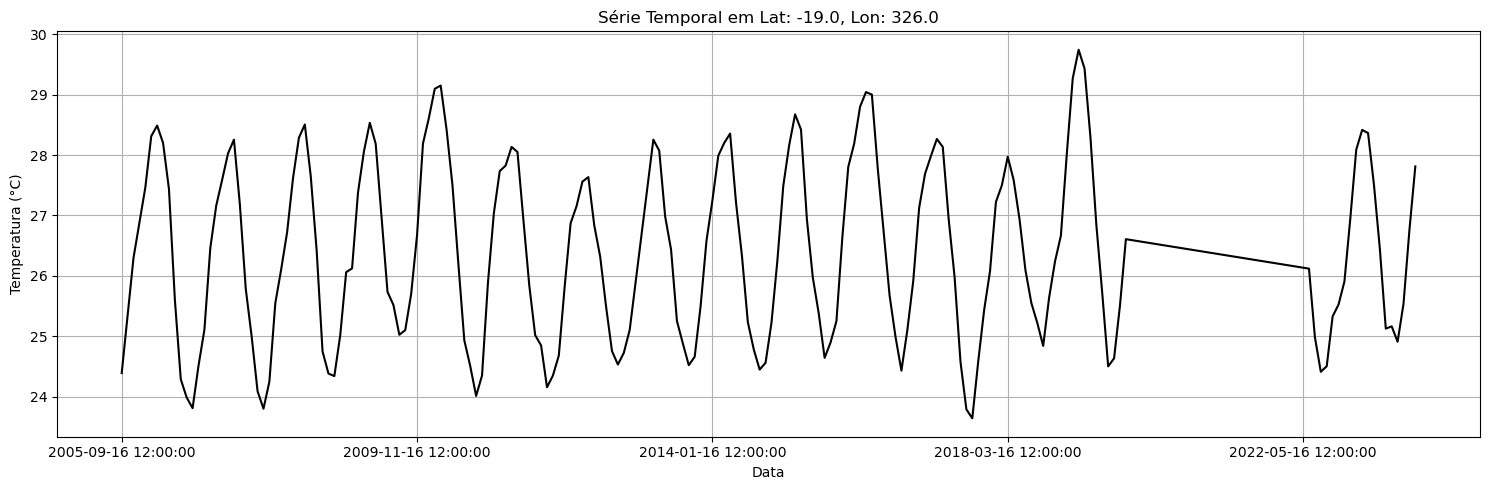

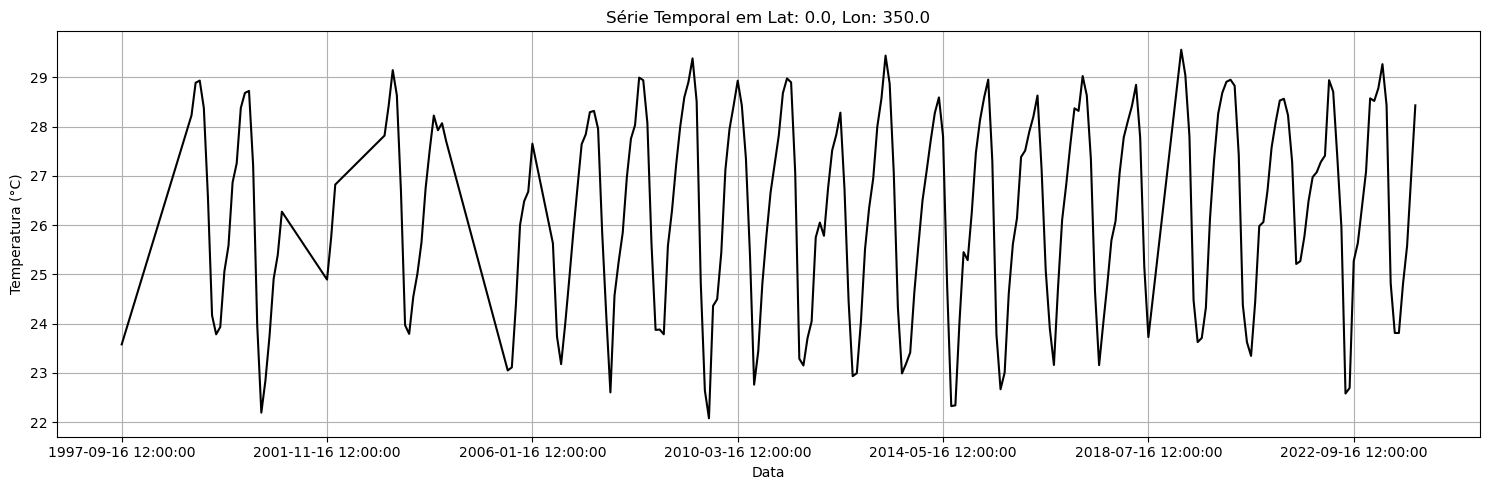

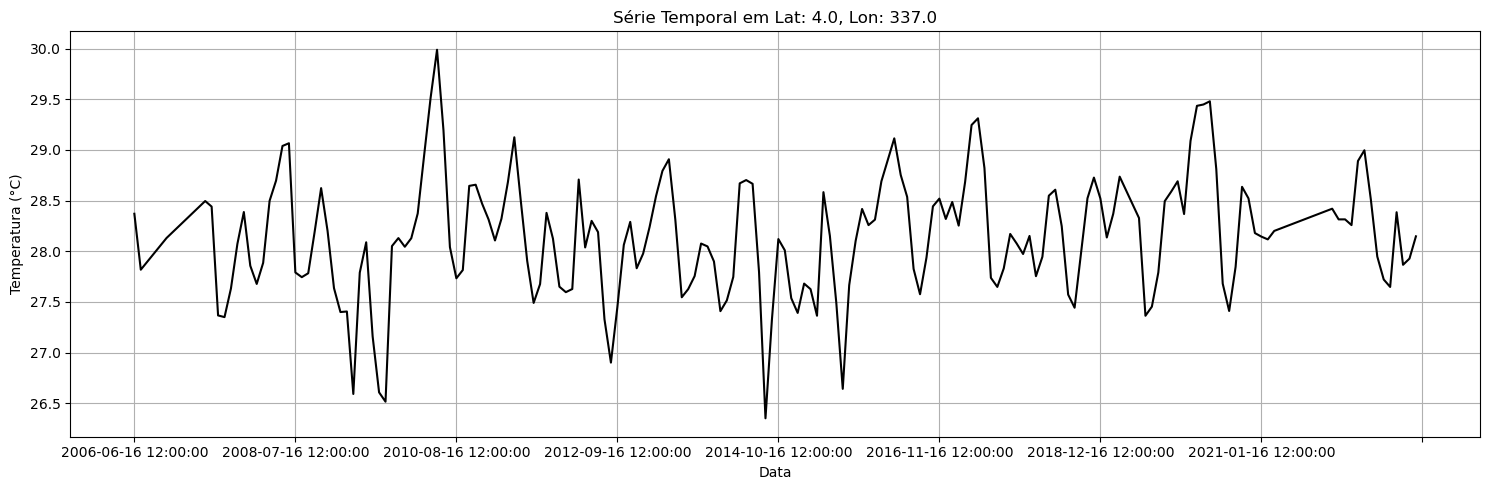

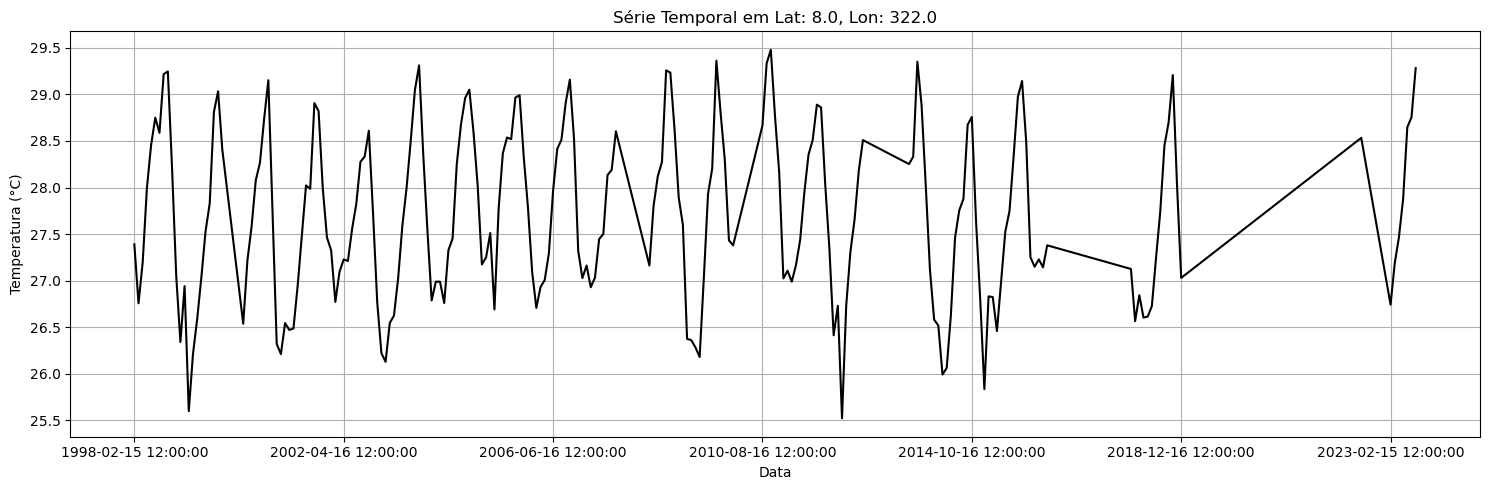

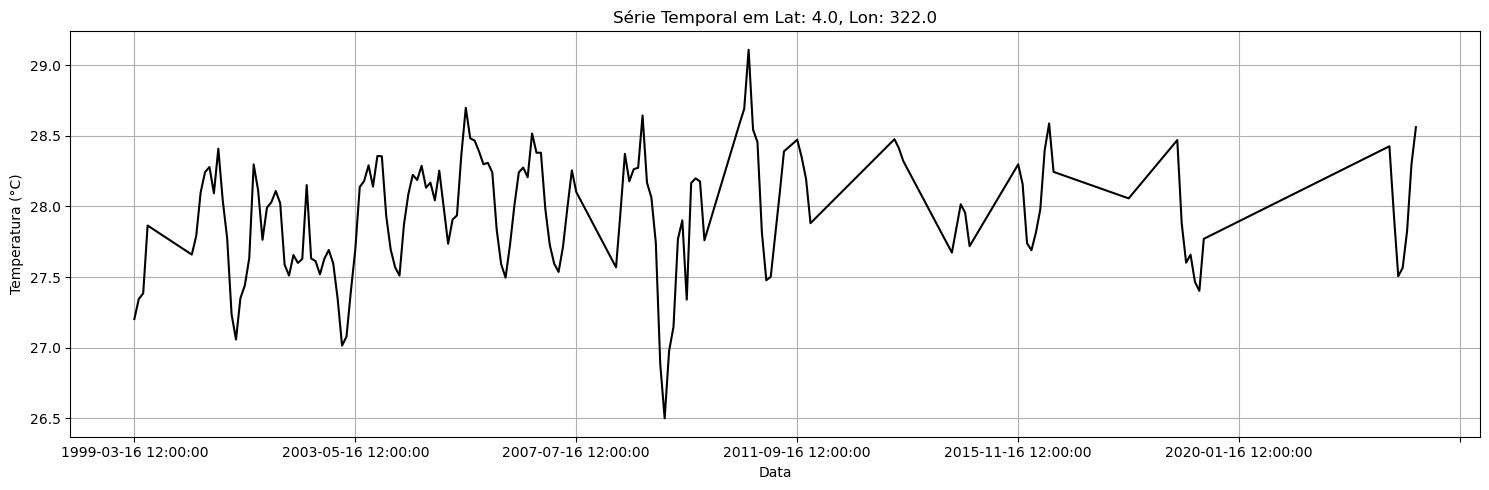

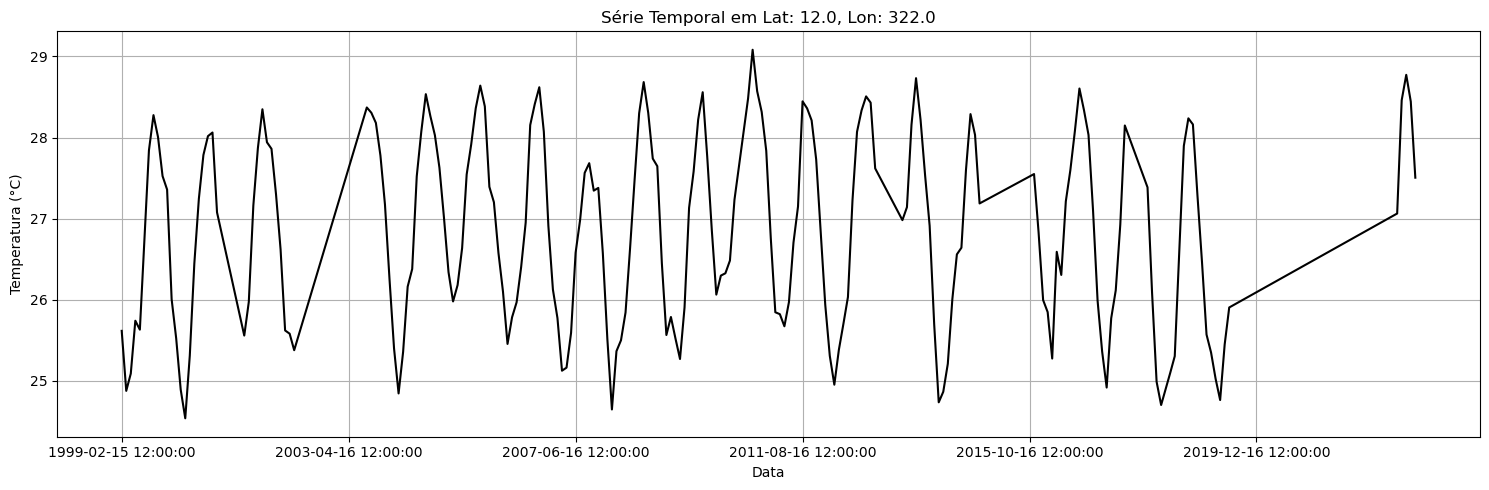

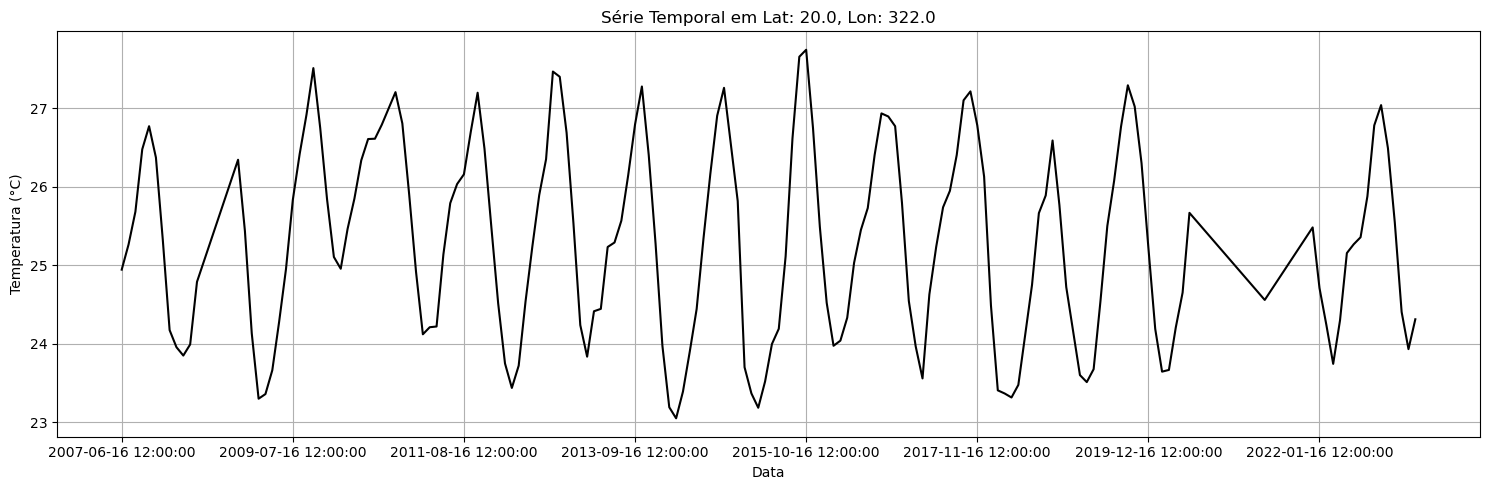

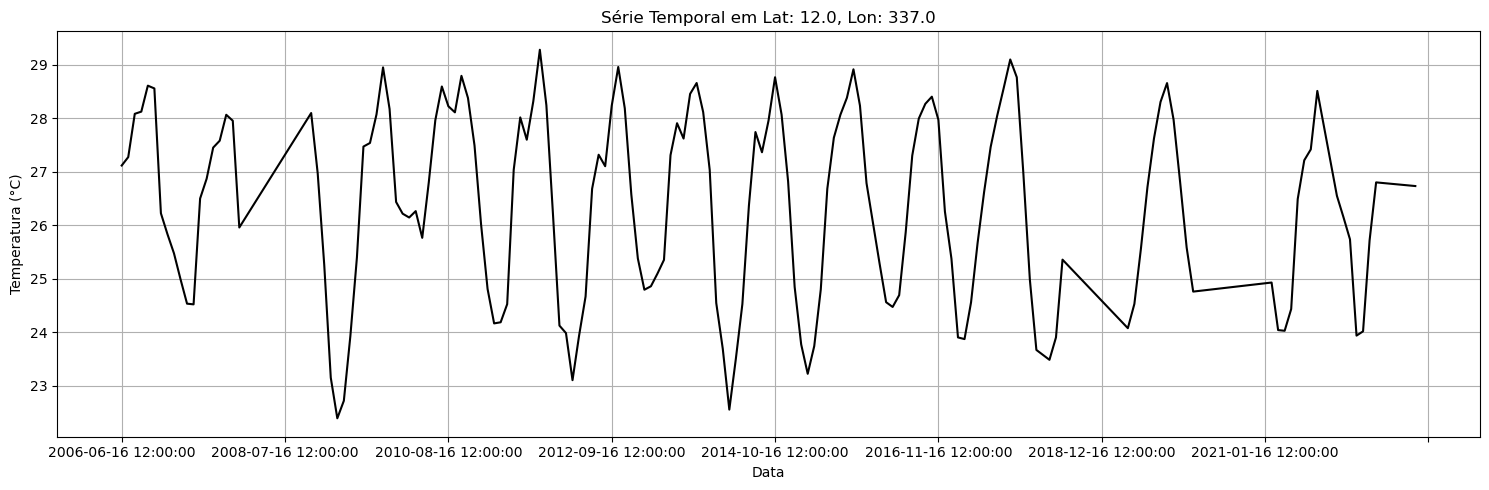

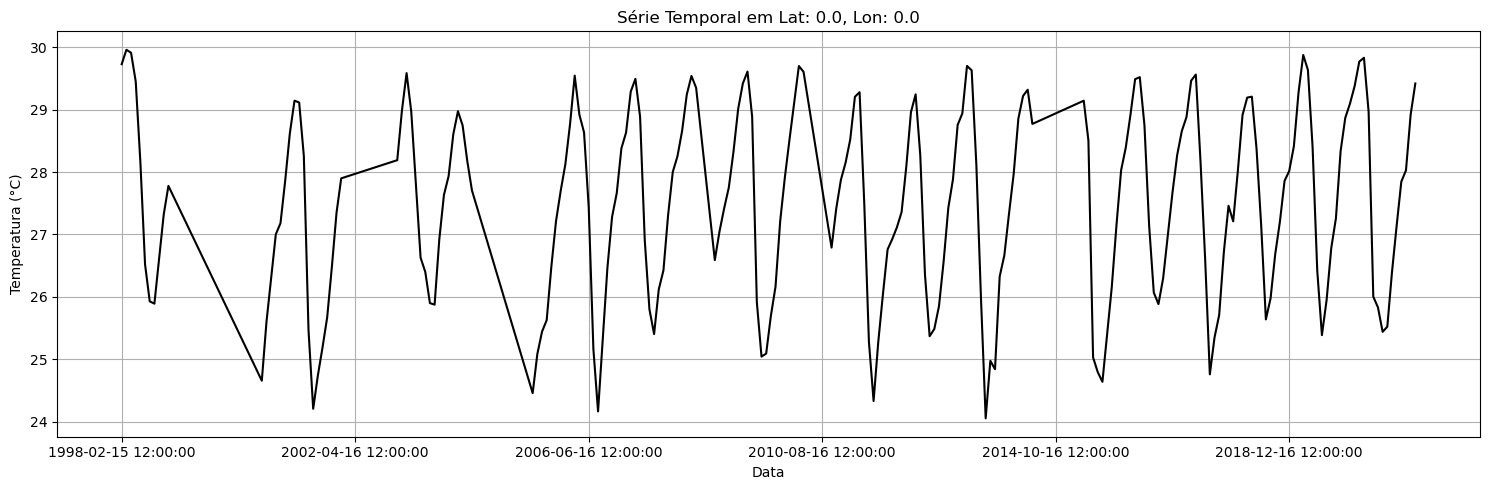

In [22]:
import pandas as pd

def ler_dados(arquivo):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base
    temperatura = ds.variables['T_25'][:]
    
    #fill_value = 1e35  
    #temperatura = np.where(temperatura == fill_value, np.nan, temperatura)
    temperatura = temperatura.squeeze()  # Remove eixos de tamanho 1

    # Converte o tempo de unidades relativas (dias desde uma data) para objetos datetime
    datas = nc.num2date(tempo, units=ds.variables['time'].units)
    
    # Cria um DataFrame do pandas
    df = pd.DataFrame({
        'Data': datas,
        'Temperatura': temperatura
    })
    
    # Define a coluna de data como o índice do DataFrame
    df.set_index('Data', inplace=True)
    
    # Interpolação linear dos dados de temperatura
    df['Temperatura_Interpolada'] = df['Temperatura'].interpolate(method='linear')
    
    return lat, lon, df

def plotar_serie_temporal(df, titulo):
    plt.figure(figsize=(15,5))

    # Utiliza os dados interpolados para plotar
    df['Temperatura_Interpolada'].plot(color='k', xlabel='Data', ylabel='Temperatura (°C)')
    
    plt.title(titulo)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/SST/*.cdf"

arquivos_netCDF = glob.glob(caminho_pasta)

for arquivo in arquivos_netCDF:
    lat, lon, df = ler_dados(arquivo)
    titulo = f"Série Temporal em Lat: {lat.mean():.1f}, Lon: {lon.mean():.1f}"
    plotar_serie_temporal(df, titulo)

# Preenchimento RH